<div class="alert alert-block alert-danger">  
    <h2><strong>Working notebook to the article:</strong></h2>
    <h1><strong>"Bioenergetic model of retrotransposon activity in cancer cells" (Life, 2025)</strong></h1>
<strong>Authors: Sergey Pavlov, Maria Duk, Vitaly V. Gursky, Maria Samsonova, Alexander Kanapin, and Anastasia Samsonova</strong> <br>
<strong>Funding: This research was funded by the Russian Science Foundation, grant No. 23–24–00153.</strong> <br>

</div>

# Import requred libruaries and set notebook settings

In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pylab import rcParams
import seaborn as sns
#
import scipy
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

In [3]:
# Check python version, system parameters and packages versions:
from watermark import watermark
print(watermark())
print(watermark(packages="numpy,pandas,tqdm,matplotlib,seaborn,scipy"))

Last updated: 2025-03-13T22:16:13.884472+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.17.2

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 191 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

numpy     : 1.26.1
pandas    : 2.1.3
tqdm      : 4.66.1
matplotlib: 3.8.1
seaborn   : 0.13.0
scipy     : 1.11.3



In [4]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [7]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
mpl.rcParams['figure.figsize'] = 6,4
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["figure.autolayout"] = True
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [8]:
# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

# Reference Stationary Solution 

Set values of variables in reference stationary solution

In [9]:
# expected observables under normal conditions:
a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0 = np.array([5.32028879e+09, 5.43892043e+06, 2.60750605e+06, 3.20098867e+09,
                                                        5.13241818e+04, 1.21841508e+08, 1.07775213e+05, 2.78154330e+07,
                                                        2.82625278e+03, 5.64255248e+03, 1.06716935e+03, 1.33614820e+04])

# Steady state reference
sty0 = np.array([a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0])

# changable parameters
A0       = 1.31e10 # energy supply [m.p.c./min]
lmd_a    = 1.47    # ATP molecules degradation rate constant [1/min]
lmd_L    = 0.37    # LINE-1 deactivation rate constant [1/min]
lmd_S    = 1.18    # SINE deactivation rate constant [1/min]

In [11]:
# Set directories
path = "./data/"
dir_save = path+"save/"
dir_pic = path+"pic/"
dir_svg = dir_pic+"svg/"

# Set: save plots or not
save_pic = False
save_svg = False

# chech directories exit, create if not
check_dir_exist(dir_save)
check_dir_exist(dir_pic)
check_dir_exist(dir_svg)

# Set the model

In [29]:
# Wild type values
awt = 5.33e9  # characteristic number of ATP
Lwt = 1064.   # number of LINE-1 in wild type
Swt = 13243.  # number of SINE in wild type

### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min]

# Add some
rib = rtot - cq0 - cL0 # number of free ribosomes
vrepl_max = Nnt*(Ng/tdiv)/0.8
k_vrepl = 0.25*a0

In [30]:
# Set dictionary with parameter names (for plotting)
par_dict_names = {
    "Ng"       : '$N_g$',
    "Q"        : '$Q$',    
    "nq"       : '$n_q$',
    "nQ"       : '$n_Q$',
    "nL"       : '$n_L$',
    "nS"       : '$n_S$',
    "Naa"      : '$N_{aa}$',
    "Nnt"      : '$N_{nt}$',
    "tdiv"      : r'$\tau$',
    #
    "rtot"     : '$r_{tot}$',
    "Xi_max_L" : r'$\chi_{maxL}$',
    "Xi_max_S" : r'$\chi_{maxS}$',
    "K_Xi_L"   : r'$K_{\chi L}$',
    "K_Xi_S"   : r'$K_{\chi S}$',
    "KL"       : '$K_L$',
    "wq"       : r'$w_q$',
    "wL"       : r'$w_L$',
    "wS"       : r'$w_S$',
    "Th_nr_q"  : r'$\theta_q$',
    "Th_nr_L"  : r'$\theta_L$',
    "Th_nr_S"  : r'$\theta_S$',
    "gm_max_q" : r'$\gamma_{maxq}$',
    "gm_max_L" : r'$\gamma_{maxL}$',
    "K_gm_q"   : r'$K_{\gamma q}$',
    "K_gm_L"   : r'$K_{\gamma L}$',
    "k_bq"     : '$k_{bq}$',
    "k_bL"     : '$k_{bL}$',
    "k_uq"     : '$k_{uq}$',
    "k_uL"     : '$k_{uL}$',
    "k_subS"   : '$k_{subS}$',
    "k_subL"   : '$k_{subL}$',
    "d_mq"     : '$d_{mq}$',
    "d_cq"     : '$d_{cq}$',
    "d_q"      : '$d_{q}$',
    "d_mL"     : '$d_{mL}$',
    "d_mS"     : '$d_{mS}$',
    "d_cL"     : '$d_{cL}$',
    "d_O1"     : '$d_{O1}$',
    "d_bL"     : '$d_{bL}$',
    "d_bS"     : '$d_{bS}$',
    # changable
    "A0"       : '$A_0$',
    "lmd_a"    : r'$\lambda_a$',
    "lmd_L"    : r'$\lambda_L$',
    "lmd_S"    : r'$\lambda_S$'
}

In [31]:
# Set dictionary with parameters (in order)
pdict = {
    "A0"       : 0,
    "Xi_max_L" : 1,
    "Xi_max_S" : 2,
    "K_Xi_L"   : 3,
    "K_Xi_S"   : 4,
    "KL"       : 5,
    "wq"       : 6,
    "wL"       : 7,
    "wS"       : 8,
    "Th_nr_q"  : 9,
    "Th_nr_L"  : 10,
    "Th_nr_S"  : 11,
    "gm_max_q" : 12,
    "gm_max_L" : 13,
    "K_gm_q"   : 14,
    "K_gm_L"   : 15,
    "k_bq"     : 16,
    "k_bL"     : 17,
    "k_uq"     : 18,
    "k_uL"     : 19,
    "k_subS"   : 20,
    "k_subL"   : 21,
    "rtot"     : 22,
    "lmd_a"    : 23,
    "d_mq"     : 24,
    "d_cq"     : 25,
    "d_q"      : 26,
    "d_mL"     : 27,
    "d_mS"     : 28,
    "d_cL"     : 29,
    "d_O1"     : 30,
    "d_bL"     : 31,
    "d_bS"     : 32,
    "lmd_L"    : 33,
    "lmd_S"    : 34
}

In [32]:
# Set list with parameters (in order)
par_list = [A0      ,
            Xi_max_L,
            Xi_max_S,
            K_Xi_L  ,
            K_Xi_S  ,
            KL      ,
            wq      ,
            wL      ,
            wS      ,
            Th_nr_q ,
            Th_nr_L ,
            Th_nr_S ,
            gm_max_q,
            gm_max_L,
            K_gm_q  ,
            K_gm_L  ,
            k_bq    ,
            k_bL    ,
            k_uq    ,
            k_uL    ,
            k_subS  ,
            k_subL  ,
            rtot    ,
            lmd_a   ,
            d_mq    ,
            d_cq    ,
            d_q     ,
            d_mL    ,
            d_mS    ,
            d_cL    ,
            d_O1    ,
            d_bL    ,
            d_bS    ,
            lmd_L   ,
            lmd_S]

# to numpy & copy
npar_list = np.array(par_list, dtype='float64')
nplist = npar_list.copy()
nplist

array([1.31e+10, 8.40e+02, 8.40e+02, 1.10e+07, 1.10e+07, 2.24e-03,
       4.64e+00, 1.00e+00, 2.00e+01, 3.80e+09, 3.80e+09, 3.80e+09,
       3.00e+02, 3.00e+02, 2.59e+04, 2.59e+04, 5.00e-08, 5.00e-08,
       1.00e-02, 1.00e-02, 5.00e-08, 5.00e-06, 9.50e+06, 1.47e+00,
       1.15e-03, 1.55e-03, 5.67e-04, 1.15e-03, 1.15e-03, 1.55e-03,
       5.67e-04, 5.67e-04, 5.67e-04, 3.70e-01, 1.18e+00])

In [33]:
# translation rates:
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# replication:
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
def ribf(cq_,cL_):
    return rtot-cq_-cL_

# Parameter-sensitive functions

In [34]:
# Function for integration
def integr_syst_par(t, y):
    A0       = nplist[0]
    Xi_max_L = nplist[1]
    Xi_max_S = nplist[2]
    K_Xi_L   = nplist[3]
    K_Xi_S   = nplist[4]
    KL       = nplist[5]
    wq       = nplist[6]
    wL       = nplist[7]
    wS       = nplist[8]
    Th_nr_q  = nplist[9]
    Th_nr_L  = nplist[10]
    Th_nr_S  = nplist[11]
    gm_max_q = nplist[12]
    gm_max_L = nplist[13]
    K_gm_q   = nplist[14]
    K_gm_L   = nplist[15]
    k_bq     = nplist[16]
    k_bL     = nplist[17]
    k_uq     = nplist[18]
    k_uL     = nplist[19]
    k_subS   = nplist[20]
    k_subL   = nplist[21]
    rtot     = nplist[22]
    lmd_a    = nplist[23]
    d_mq     = nplist[24]
    d_cq     = nplist[25]
    d_q      = nplist[26]
    d_mL     = nplist[27]
    d_mS     = nplist[28]
    d_cL     = nplist[29]
    d_O1     = nplist[30]
    d_bL     = nplist[31]
    d_bS     = nplist[32]
    lmd_L    = nplist[33]
    lmd_S    = nplist[34]
    
    # translation rates:
    def vq(cq_, a_):
        return gm_max_q/nq*cq_*a_/(K_gm_q+a_)
    
    def vL(cL_,a_):
        return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)
    
    # integration rates:
    def vintL(bL_,O1_,a_):
        return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)
    
    def vintS(bS_,a_):
        return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)
    
    # transcription rates:
    def om_q(a_):
        return Q*wq*a_/(Th_nr_q+a_)
    
    def om_L(L_,a_):
        return L_*wL*a_/(Th_nr_L+a_)
    
    def om_S(S_,a_):
        return S_*wS*a_/(Th_nr_S+a_)
    
    # replication:
    def vreplf(a_,bL_,O1_,bS_):
        return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)
    
    # ribosomes:
    def ribf(cq_,cL_):
        return rtot-cq_-cL_
        
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

In [35]:
# Function for integration
def solve_syst_par(y):
    A0       = nplist[0]
    Xi_max_L = nplist[1]
    Xi_max_S = nplist[2]
    K_Xi_L   = nplist[3]
    K_Xi_S   = nplist[4]
    KL       = nplist[5]
    wq       = nplist[6]
    wL       = nplist[7]
    wS       = nplist[8]
    Th_nr_q  = nplist[9]
    Th_nr_L  = nplist[10]
    Th_nr_S  = nplist[11]
    gm_max_q = nplist[12]
    gm_max_L = nplist[13]
    K_gm_q   = nplist[14]
    K_gm_L   = nplist[15]
    k_bq     = nplist[16]
    k_bL     = nplist[17]
    k_uq     = nplist[18]
    k_uL     = nplist[19]
    k_subS   = nplist[20]
    k_subL   = nplist[21]
    rtot     = nplist[22]
    lmd_a    = nplist[23]
    d_mq     = nplist[24]
    d_cq     = nplist[25]
    d_q      = nplist[26]
    d_mL     = nplist[27]
    d_mS     = nplist[28]
    d_cL     = nplist[29]
    d_O1     = nplist[30]
    d_bL     = nplist[31]
    d_bS     = nplist[32]
    lmd_L    = nplist[33]
    lmd_S    = nplist[34]
    
    # translation rates:
    def vq(cq_, a_):
        return gm_max_q/nq*cq_*a_/(K_gm_q+a_)
    
    def vL(cL_,a_):
        return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)
    
    # integration rates:
    def vintL(bL_,O1_,a_):
        return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)
    
    def vintS(bS_,a_):
        return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)
    
    # transcription rates:
    def om_q(a_):
        return Q*wq*a_/(Th_nr_q+a_)
    
    def om_L(L_,a_):
        return L_*wL*a_/(Th_nr_L+a_)
    
    def om_S(S_,a_):
        return S_*wS*a_/(Th_nr_S+a_)

    # replication:
    def vreplf(a_,bL_,O1_,bS_):
        return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)
    
    # ribosomes:
    def ribf(cq_,cL_):
        return rtot-cq_-cL_
        
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

<div class="alert alert-block alert-info"> 
    <h1><strong>Calculations</strong></h1>
</div>

# Check reference

In [36]:
# Find roots numerically
incond = sty0.copy() # reference
root0 = root(solve_syst_par, incond, method='lm', options={'maxiter':10000})
print("success:", root0.success)
print("niter =", root0.nfev)
print(root0.x)

success: True
niter = 14
[5.32028879e+09 5.43892043e+06 2.60750605e+06 3.20098867e+09
 5.13241818e+04 1.21841508e+08 1.07775213e+05 2.78154330e+07
 2.82625278e+03 5.64255248e+03 1.06716935e+03 1.33614820e+04]


In [37]:
# Check with least_squares
incond = root0.x.copy()
lsq = least_squares(solve_syst_par, incond, method='dogbox', bounds=(0, np.inf), max_nfev=25)
print("message:", lsq.message)
print("success:", lsq.success)
print("niter =", lsq.nfev)
print("root:\n", lsq.x)
print("O-C:\n", solve_syst_par(lsq.x))

message: `xtol` termination condition is satisfied.
success: True
niter = 2
root:
 [5.32028879e+09 5.43892043e+06 2.60750605e+06 3.20098867e+09
 5.13241818e+04 1.21841508e+08 1.07775213e+05 2.78154330e+07
 2.82625278e+03 5.64255248e+03 1.06716935e+03 1.33614820e+04]
O-C:
 [-1.34110451e-07  7.36690708e-11 -2.67391442e-10  0.00000000e+00
  1.35713663e-12  0.00000000e+00  8.52651283e-14 -1.81898940e-12
 -3.11972670e-12  1.26698652e-12  0.00000000e+00 -1.81898940e-12]


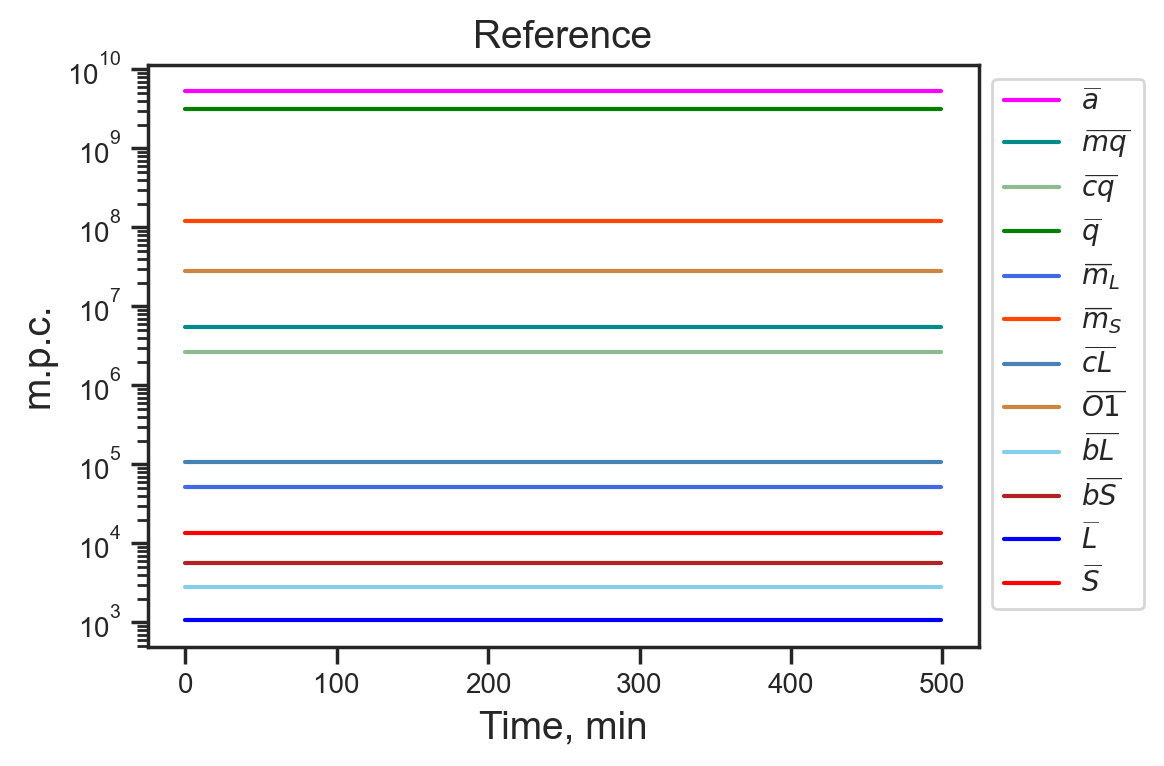

In [38]:
# Reference solution
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 500 #int((t_finish-t_start)/step)

# set initial conditions (random)
nplist = npar_list.copy()
incond = root0.x.copy()

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')

# Plot solution
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
ax.set_title('Reference')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

# Calculate partial derivatives

In [39]:
# Set labels
transposon_labels = ["Xi_max_L","Xi_max_S","K_Xi_L","K_Xi_S","KL","wL","wS","Th_nr_L","Th_nr_S","gm_max_L",
                     "K_gm_L","k_bL","k_uL","k_subS","k_subL","d_mL","d_mS","d_cL","d_O1","d_bL","lmd_L","lmd_S"]
transposon_names = [par_dict_names[key] for key in transposon_labels]
par_keys = ["A0","Xi_max_L","Xi_max_S","K_Xi_L","K_Xi_S","KL","wq","wL","wS","Th_nr_q","Th_nr_L","Th_nr_S",
            "gm_max_q","gm_max_L","K_gm_q","K_gm_L","k_bq","k_bL","k_uq","k_uL","k_subS","k_subL","rtot","lmd_a","d_mq",
            "d_cq","d_q","d_mL","d_mS","d_cL","d_O1","d_bL","d_bS","lmd_L","lmd_S"]
var_keys = np.array(['a','mq','cq','q','mL','mS','cL','O1','bL','bS','L','S'])

In [40]:
# initialize
incond = root0.x.copy()
df = pd.DataFrame(columns=var_keys).T

# loop by model-parameters
for key in tqdm(par_keys):
    h = 1e-6
    while True:
        #
        nplist = npar_list.copy()
        nplist[pdict[key]] += nplist[pdict[key]]*h
        root2 = root(solve_syst_par, incond, method='lm').x
        #
        nplist = npar_list.copy()
        nplist[pdict[key]] -= nplist[pdict[key]]*h
        root1 = root(solve_syst_par, incond, method='lm').x
        #
        diff = (root2-root1)/(2*h)
        if (diff==0).any():
            if h >= 0.1:
                print(f"failed with {key}")
                break
            else:
                h *= 10
                continue
        else:
            srs = pd.Series(diff, index=var_keys, name=key)
            df = pd.concat([df, srs], axis=1)
            break

100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 431.95it/s]


In [41]:
# check pdict
nplist = npar_list.copy()

# copy DataFrame
dfD = df.copy(deep=True)

# # write to pickle
# dfD.to_pickle(dir_save+'dfD.pkl')

# # read from pickle
# dfD = pd.read_pickle(dir_save+'dfD.pkl')

In [42]:
# print DataFrame
dfD.T

,a,mq,cq,q,mL,mS,cL,O1,bL,bS,L,S
A0,6.820405e+09,3.285867e+06,1.110260e+06,1.362982e+09,5.664247e+04,1.895048e+08,9.972186e+04,2.672899e+07,-1.417812e+03,5.408077e+03,-5.325148e+02,1.284159e+04
Xi_max_L,-6.289189e+08,-2.728369e+05,-1.247534e+05,-1.531498e+08,5.179685e+04,1.161902e+08,1.090178e+05,2.804702e+07,3.948011e+02,5.691405e+03,1.216000e+03,1.347390e+04
Xi_max_S,5.258945e+07,2.281140e+04,1.043387e+04,1.280882e+07,-4.336639e+03,-9.698103e+06,-9.127233e+03,-2.347760e+06,-2.713131e+02,-6.117776e+03,-1.024252e+02,-1.125049e+03
K_Xi_L,1.297643e+06,5.629435e+02,2.574031e+02,3.159933e+05,-1.068720e+02,-2.397343e+05,-2.249355e+02,-5.786918e+04,-8.145896e-01,-1.174303e+01,-2.508962e+00,-2.780060e+01
K_Xi_S,-1.085081e+05,-4.706718e+01,-2.152822e+01,-2.642846e+04,8.947809e+00,2.001016e+04,1.883227e+01,4.844146e+03,5.597983e-01,1.262276e+01,2.113331e-01,2.321320e+00
KL,-1.009321e+04,-4.378613e+00,-2.002111e+00,-2.457857e+03,8.312672e-01,1.864687e+03,1.749584e+00,4.501138e+02,6.335995e-03,9.133873e-02,1.951594e-02,2.162360e-01
wq,-1.725488e+09,5.271180e+06,1.834312e+06,2.251807e+09,-1.460517e+03,-5.550869e+07,-3.170124e+04,-8.489172e+06,4.182900e+02,-1.718572e+03,1.572235e+02,-4.078494e+03
wL,-1.597928e+09,-6.873756e+05,-3.212976e+05,-3.944313e+08,1.426373e+05,3.294183e+08,2.998634e+05,7.906916e+07,1.054192e+03,1.604464e+04,3.974416e+02,3.798518e+04
wS,3.299323e+08,1.256362e+05,7.842584e+04,9.627696e+07,-6.025078e+04,-2.902336e+06,-1.257681e+05,-3.240834e+07,-3.504637e+03,-6.574935e+03,-1.323205e+03,-1.556764e+04
Th_nr_q,7.189306e+08,-2.196255e+06,-7.642726e+05,-9.382231e+08,6.085297e+02,2.312789e+07,1.320843e+04,3.537043e+06,-1.742820e+02,7.160489e+02,-6.550770e+01,1.699319e+03


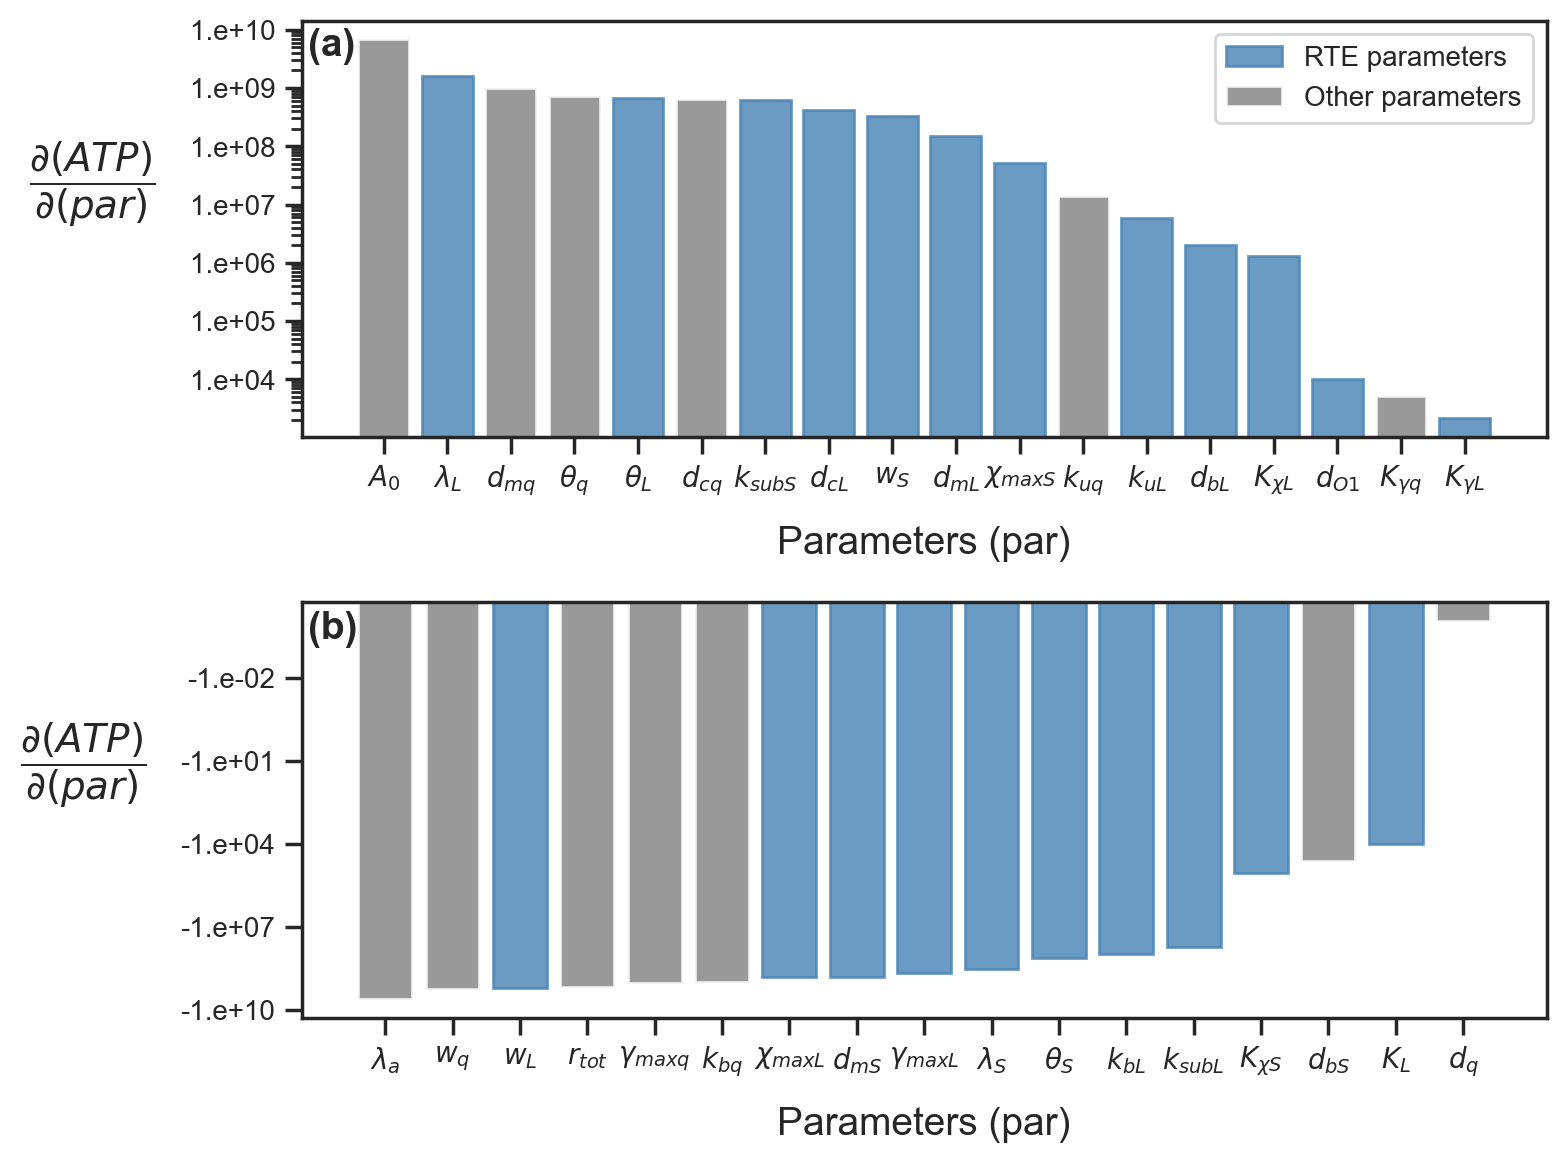

In [46]:
# Get derivatives by energy (a)
s = dfD.loc['a',:].T.sort_values(ascending=False)

# PLot O-C
fig, axs = plt.subplots(2, figsize=(8,6))

# Set annotation. Subplots names 
annot = ['(a)', '(b)']

## First plot ###
# Plot bar chart of energy consumption by rates:
s1 = s[s>0]
x_ticks = s1.index.to_numpy()
for i,tic in enumerate(x_ticks):
    x_ticks[i] = par_dict_names[tic]
bar_len = np.arange(len(s1))

# matplotlib bar
bar = axs[0].bar(bar_len, s1, align='center', alpha=0.8, color='grey')

# change color for transposons
for i in range(len(bar)):
    if x_ticks[i] in transposon_names:
        bar[i].set_color('steelblue')

#plt.title('Energy consumption')
#plt.bar_label(bar,padding=3,rotation = 0)
axs[0].set_xticks(bar_len, x_ticks, rotation = 0)
axs[0].set_yscale("log")
y_ticks = axs[0].get_yticks()[2:-2]#.tolist()
y_ticks_lab = [np.format_float_scientific(y_ticks[i]) for i in range(len(y_ticks))]
axs[0].set_yticks(y_ticks, y_ticks_lab, rotation = 0)
#axs[0].set_xticklabels(axs[0].get_xticks(), rotation = 45)
axs[0].set_xlabel("Parameters (par)", labelpad = 10)
axs[0].set_ylabel(r'$\dfrac{\partial(ATP)}{\partial(par)}$', rotation = 0, labelpad = 35)

# Legend
#axs[0].legend(["Transposon parameters" , "Other parameters"], bbox_to_anchor=[1.,1])
bar[1].set_label('RTE parameters')
bar[2].set_label('Other parameters')
axs[0].legend(bbox_to_anchor=[1.,1])

## Second plot ###
# Plot bar chart of energy consumption by rates:
s2 = abs(s[s<0])
x_ticks = s2.index.to_numpy()
for i,tic in enumerate(x_ticks):
    x_ticks[i] = par_dict_names[tic]
bar_len = np.arange(len(s2))
#lab = [format(num, "e") for num in round(-s1,2)]

# matplotlib bar
bar = axs[1].bar(bar_len, s2, align='center', alpha=0.8, color='grey')

# change color for transposons
for i in range(len(bar)):
    if x_ticks[i] in transposon_names:
        bar[i].set_color('steelblue')

#plt.title('Energy consumption')
#plt.bar_label(bar,padding=3,rotation = 0,labels=lab)
axs[1].set_xticks(bar_len, x_ticks, rotation = 0)
axs[1].set_yscale("log")
y_ticks = axs[1].get_yticks()[2:-2]#.tolist()
y_ticks_lab = [np.format_float_scientific(-y_ticks[i]) for i in range(len(y_ticks))]
axs[1].set_yticks(y_ticks, y_ticks_lab, rotation = 0)

#axs[1].set_xticklabels(axs[1].get_xticks(), rotation = 45)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
axs[1].set_xlabel("Parameters (par)", labelpad = 10)
axs[1].set_ylabel(r'$\dfrac{\partial(ATP)}{\partial(par)}$', rotation = 0, labelpad = 35)

### Add subplots names ###
# plot 1
i = 0
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmin+(xmax-xmin)*0.005,ymax+(ymin-ymax)*0.25), ha='left', va='top', fontsize=14, weight="bold")
# plot 2
i = 1
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmin+(xmax-xmin)*0.005,ymax+(ymin-ymax)*1e-15), ha='left', va='top', fontsize=14, weight="bold")

# plt.gca()
plt.tight_layout()
fig_name = "f1_bar"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

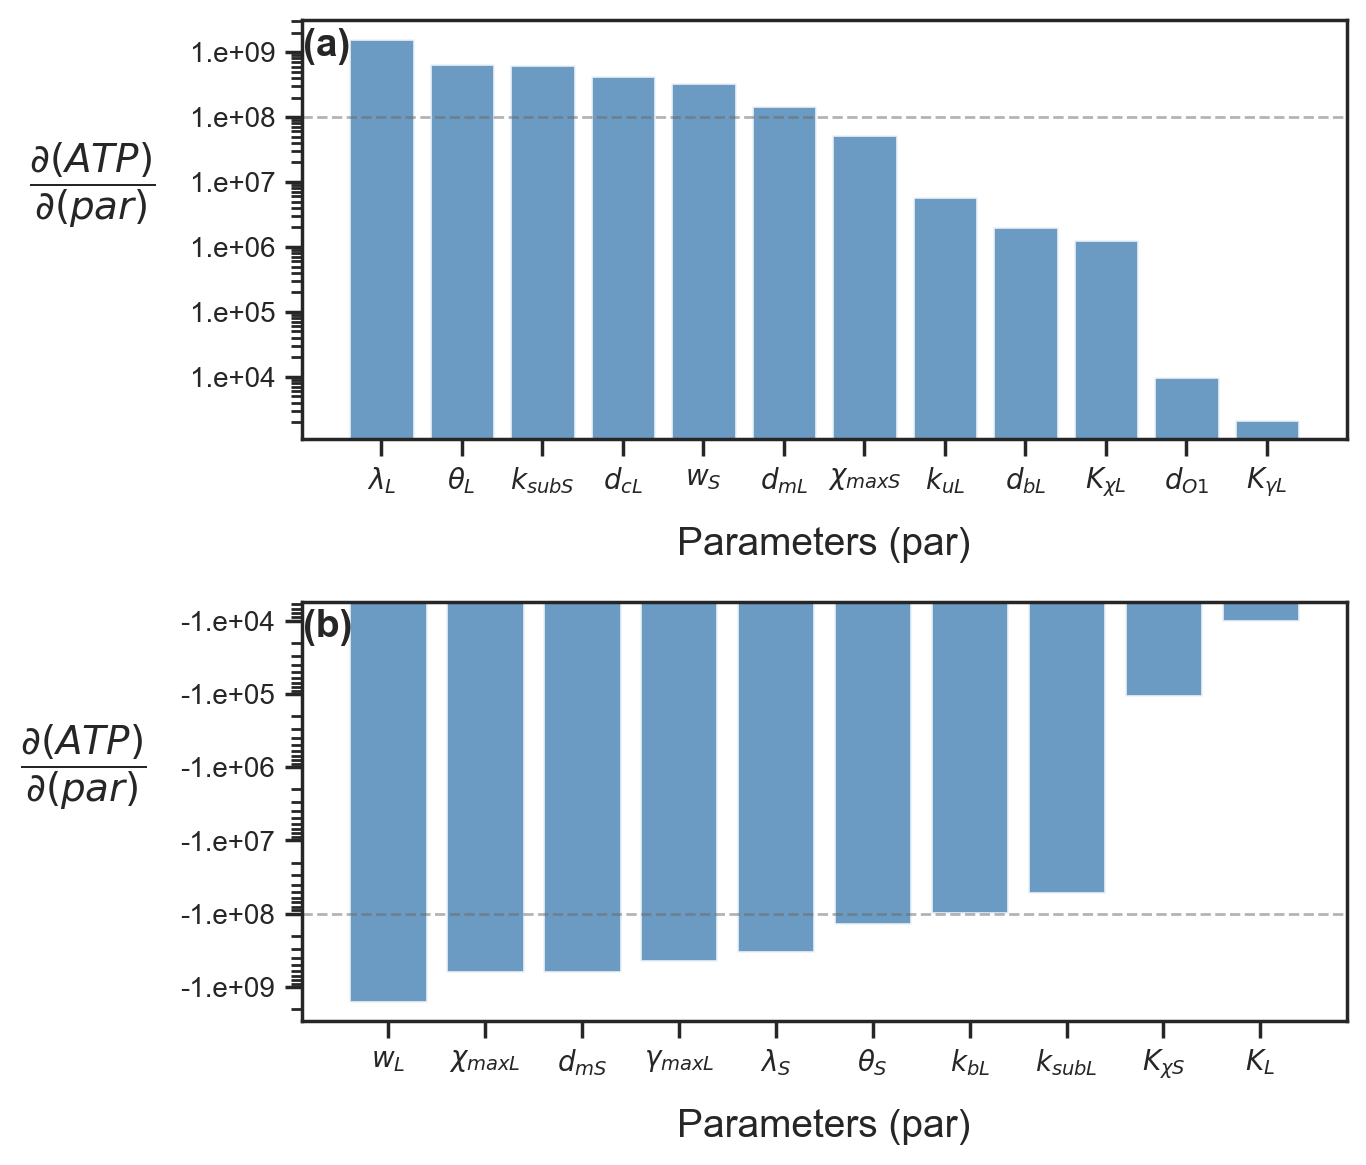

In [48]:
# DataFrame with transposone parameters
st = dfD.loc['a',transposon_labels].T.sort_values(ascending=False)

# PLot O-C
fig, axs = plt.subplots(2, figsize=(7,6))

# Set annotation. Subplots names 
annot = ['(a)', '(b)']

## First plot ###
# Plot bar chart of energy consumption by rates:
s1 = st[st>0]
x_ticks = s1.index.to_numpy()
for i,tic in enumerate(x_ticks):
    x_ticks[i] = par_dict_names[tic]
bar_len = np.arange(len(s1))

# matplotlib bar
bar = axs[0].bar(bar_len, s1, align='center', alpha=0.8, color='steelblue')
axs[0].axhline(y = 1e8, color = 'dimgrey', linestyle = '--', alpha=0.5)

#plt.title('Energy consumption')
#plt.bar_label(bar,padding=3,rotation = 0)
axs[0].set_xticks(bar_len, x_ticks, rotation = 0)
axs[0].set_yscale("log")
y_ticks = axs[0].get_yticks()[2:-2]#.tolist()
y_ticks_lab = [np.format_float_scientific(y_ticks[i]) for i in range(len(y_ticks))]
axs[0].set_yticks(y_ticks, y_ticks_lab, rotation = 0)
#axs[0].set_xticklabels(axs[0].get_xticks(), rotation = 45)
axs[0].set_xlabel("Parameters (par)", labelpad = 10)
axs[0].set_ylabel(r'$\dfrac{\partial(ATP)}{\partial(par)}$', rotation = 0, labelpad = 35)

## Second plot ###
# Plot bar chart of energy consumption by rates:
s2 = abs(st[st<0])
x_ticks = s2.index.to_numpy()
for i,tic in enumerate(x_ticks):
    x_ticks[i] = par_dict_names[tic]
bar_len = np.arange(len(s2))

# matplotlib bar
bar = axs[1].bar(bar_len, s2, align='center', alpha=0.8, color='steelblue')
axs[1].axhline(y = 1e8, color = 'dimgrey', linestyle = '--', alpha=0.5)

#plt.title('Energy consumption')
#plt.bar_label(bar,padding=3,rotation = 0,labels=lab)
axs[1].set_xticks(bar_len, x_ticks, rotation = 0)
axs[1].set_yscale("log")
y_ticks = axs[1].get_yticks()[2:-2]#.tolist()
y_ticks_lab = [np.format_float_scientific(-y_ticks[i]) for i in range(len(y_ticks))]
axs[1].set_yticks(y_ticks, y_ticks_lab, rotation = 0)

#axs[1].set_xticklabels(axs[1].get_xticks(), rotation = 45)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
axs[1].set_xlabel("Parameters (par)", labelpad = 10)
axs[1].set_ylabel(r'$\dfrac{\partial(ATP)}{\partial(par)}$', rotation = 0, labelpad = 35)

### Add subplots names ###
# plot 1
i = 0
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmin+(xmax-xmin)*0.001,ymax+(ymin-ymax)*0.25), ha='left', va='top', fontsize=14, weight="bold")
# plot 2
i = 1
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmin+(xmax-xmin)*0.001,ymax+(ymin-ymax)*0.5e-6), ha='left', va='top', fontsize=14, weight="bold")


#plt.gca()
plt.tight_layout()
fig_name = "f2_bar"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

# Variate parameters

In [49]:
# Set dictionary with parameter-names
par_pos = [
    'lmd_L'    ,
    'Th_nr_L'  ,
    'k_subS'   ,
    'd_cL'     ,
    'wS'       ,
    'd_mL'     ,
]

par_neg = [
    'wL'       ,
    'Xi_max_L' ,
    'd_mS'     ,
    'gm_max_L' ,
    'lmd_S'    ,
    'Th_nr_S'  ,
    'k_bL'     ,
]

In [50]:
# Set arrays with coefficients
cfs_pos = np.array([1,0.75,0.5,0.35,0.25,0.2,0.15,0.1,0.075,0.05])
cfs_neg = np.array([1,1.5,2,3,4,5,7.5,10,15,20])

In [52]:
# Positive derivatives (delete)
cfs = cfs_pos.copy()
thresh = 1e-7

#  # Turn interactive plotting off
# plt.ioff()

# Time
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# loop by parameters with positive derivatives (delete)
np_a = np.zeros((len(par_pos),len(cfs)))
for i,key in tqdm(enumerate(par_pos)):
    # init. cond.
    incond = root0.x.copy()
    # loop by coeffs
    for j,cf in enumerate(cfs):
        nplist = npar_list.copy()
        nplist[pdict[key]] = cf*npar_list[pdict[key]]
        
        # integrate
        sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')
        if (np.abs(sol.y[:,-2]-sol.y[:,-1]) < sol.y[:,-1]*thresh).all():
            np_a[i,j] = sol.y[0,-1]
            incond = sol.y[:,-1]
        else:
            np_a[i,j] = np.nan
        
        # Plot solution
        fig, ax = plt.subplots()
        
        ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
        ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
        ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
        ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
        ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
        ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
        ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
        ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
        ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
        ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
        ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
        ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")
        
        # Set axes
        ax.set_title(f"{key} = {cf:.3f} * {npar_list[pdict[key]]:.2e} = {nplist[pdict[key]]:.2e}")
        ax.set_xlabel('Time, min')
        ax.set_ylabel('m.p.c.')
        ax.set_yscale('log')
        ax.axis('auto')
        ax.legend(bbox_to_anchor=[1.,1])
        plt.tight_layout()
        
        # Check directories exist. Create if not 
        dir_pic_tmp = dir_pic+f"var_pars/{key}/"
        check_dir_exist(dir_pic_tmp)
        if save_pic: fig.savefig(dir_pic_tmp+f"{key}_{cf:.3f}".replace('.','_')+".png", bbox_inches='tight')
        # plt.show()
        plt.close(fig)

# to DataFrame
df_a_pos = pd.DataFrame(np_a, columns=cfs, index=par_pos)
df_a_pos

6it [00:22,  3.69s/it]


,1.000,0.750,0.500,0.350,0.250,0.200,0.150,0.100,0.075,0.050
lmd_L,5.320289e+09,4.771123e+09,3.605003e+09,2.171031e+09,8.785400e+08,4.205814e+08,NaN,NaN,NaN,NaN
Th_nr_L,5.320289e+09,5.127816e+09,4.859241e+09,4.633409e+09,4.434967e+09,4.313010e+09,4.168474e+09,3.990470e+09,3.882681e+09,3.755942e+09
k_subS,5.320289e+09,5.115171e+09,4.729128e+09,4.294691e+09,3.836496e+09,3.537983e+09,3.194509e+09,2.823007e+09,2.635911e+09,2.453361e+09
d_cL,5.320289e+09,5.192158e+09,4.994861e+09,4.817117e+09,4.657686e+09,4.560841e+09,4.449578e+09,4.321097e+09,4.249406e+09,4.172182e+09
wS,5.320289e+09,5.203925e+09,4.926507e+09,4.454923e+09,3.576033e+09,2.710021e+09,NaN,NaN,NaN,NaN
d_mL,5.320289e+09,5.280630e+09,5.235329e+09,5.204934e+09,5.183127e+09,5.171720e+09,5.159957e+09,5.147823e+09,5.141610e+09,5.135298e+09


In [53]:
# Negative derivatives (multiply)
cfs = cfs_neg.copy()
thresh = 1e-7

# Time
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# loop by parameters with negative derivatives (multiply)
np_a = np.zeros((len(par_neg),len(cfs)))
for i,key in tqdm(enumerate(par_neg)):
    # init. cond.
    incond = root0.x.copy()
    # loop by coeffs
    for j,cf in enumerate(cfs):
        nplist = npar_list.copy()
        nplist[pdict[key]] = cf*npar_list[pdict[key]]
        
        # integrate
        sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')
        if (np.abs(sol.y[:,-2]-sol.y[:,-1]) < sol.y[:,-1]*thresh).all():
            np_a[i,j] = sol.y[0,-1]
            incond = sol.y[:,-1]
        else:
            np_a[i,j] = np.nan
        
        # Plot solution
        fig, ax = plt.subplots()
        
        ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
        ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
        ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
        ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
        ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
        ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
        ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
        ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
        ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
        ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
        ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
        ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")
        
        # Set axes
        ax.set_title(f"{key} = {cf:.3f} * {npar_list[pdict[key]]:.2e} = {nplist[pdict[key]]:.2e}")
        ax.set_xlabel('Time, min')
        ax.set_ylabel('m.p.c.')
        ax.set_yscale('log')
        ax.axis('auto')
        ax.legend(bbox_to_anchor=[1.,1])
        plt.tight_layout()
        
        # Check directories exist. Create if not 
        dir_pic_tmp = dir_pic+f"var_pars/{key}/"
        check_dir_exist(dir_pic_tmp)
        if save_pic: fig.savefig(dir_pic_tmp+f"{key}_{cf:.3f}".replace('.','_')+".png", bbox_inches='tight')
        # plt.show()
        plt.close(fig)

# to DataFrame
df_a_neg = pd.DataFrame(np_a, columns=cfs, index=par_neg)
df_a_neg

7it [00:25,  3.70s/it]


,1.0,1.5,2.0,3.0,4.0,5.0,7.5,10.0,15.0,20.0
wL,5.320289e+09,4.485670e+09,3.605004e+09,1.962261e+09,8.785400e+08,4.205820e+08,NaN,NaN,NaN,NaN
Xi_max_L,5.320289e+09,5.013246e+09,4.725006e+09,4.222041e+09,3.825972e+09,3.525672e+09,3.058270e+09,2.808323e+09,2.559648e+09,2.438771e+09
d_mS,5.320289e+09,5.015325e+09,4.729138e+09,4.229857e+09,3.836511e+09,3.537993e+09,3.072498e+09,2.823008e+09,2.574373e+09,2.453361e+09
gm_max_L,5.320289e+09,5.125262e+09,4.973735e+09,4.755277e+09,4.606536e+09,4.499308e+09,4.329294e+09,4.230239e+09,4.120123e+09,4.060481e+09
lmd_S,5.320289e+09,5.140584e+09,4.926514e+09,4.360986e+09,3.576028e+09,2.710022e+09,NaN,NaN,NaN,NaN
Th_nr_S,5.320289e+09,5.248525e+09,5.170065e+09,4.988250e+09,4.761535e+09,4.466707e+09,3.031908e+09,NaN,NaN,NaN
k_bL,5.320289e+09,5.286224e+09,5.267535e+09,5.247601e+09,5.237122e+09,5.230660e+09,5.221833e+09,5.217325e+09,5.212753e+09,5.210443e+09


In [54]:
# # Write to pickle
# df_a_pos.to_pickle(dir_save+"df_a_pos.pkl")
# df_a_neg.to_pickle(dir_save+"df_a_neg.pkl")

# # Read from pickle
# df_a_pos = pd.read_pickle(dir_save+"df_a_pos.pkl")
# df_a_neg = pd.read_pickle(dir_save+"df_a_neg.pkl")

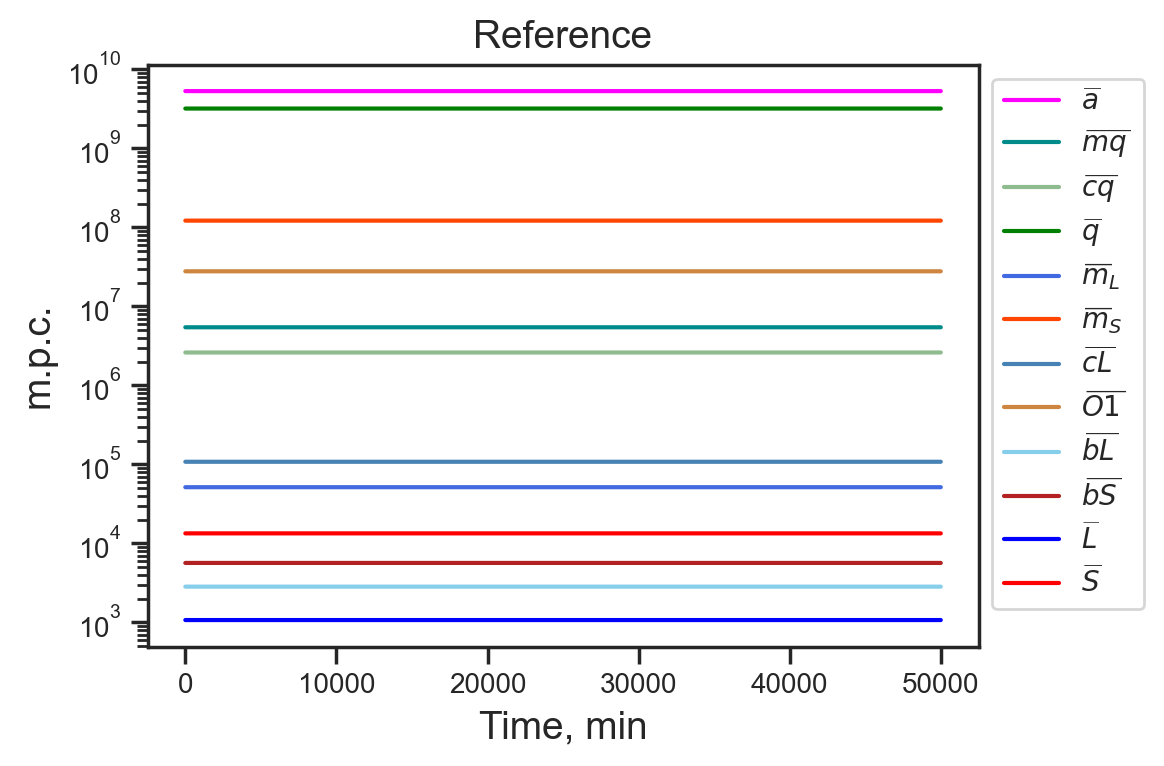

In [55]:
# Check with reference solution
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# set initial conditions
incond = root0.x.copy()
nplist = npar_list.copy()

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot reference
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
ax.set_title('Reference')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

In [56]:
# Set linestyles
line_style1 = [
    'r-',
    'g-',
    'b-',
    'c-',
    'm-',
    'k-',
]

line_style2 = [
    'r-.',
    'g-.',
    'b-.',
    'y-.',
    'c-.',
    'm-.',
    'k:',
]

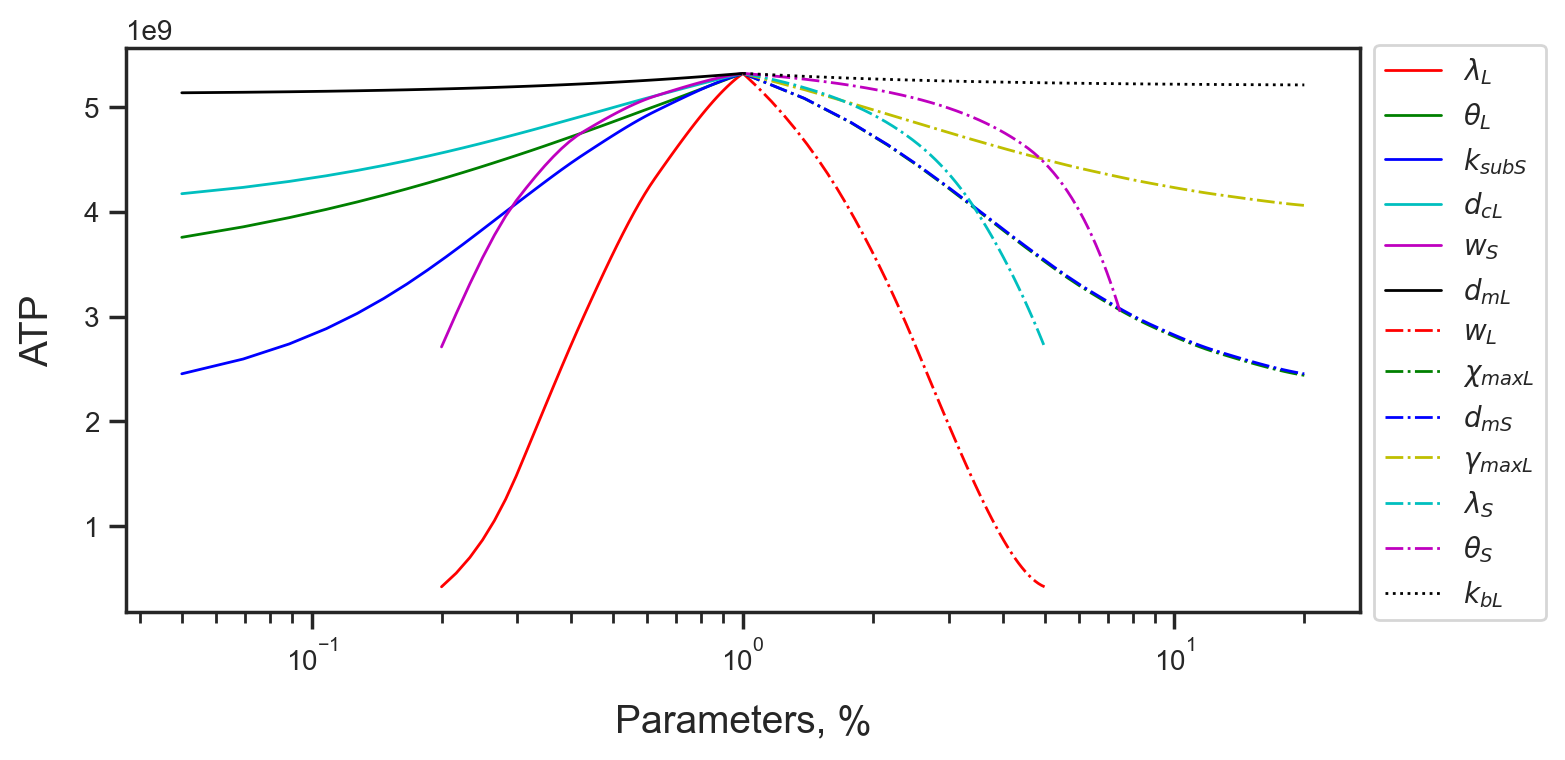

In [57]:
# PLot ATP by parameters
fig, ax = plt.subplots(figsize=(8,4))

# Process positive 
i = 0
for name,s in df_a_pos.iterrows():
    # interpolate
    x = df_a_pos.columns.values
    y = s.values
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    X_Y_Spline = interp1d(x, y, kind='quadratic')
    x1 = np.linspace(x.min(), x.max(), 50)
    y1 = X_Y_Spline(x1)
    # Plot
    ax.plot(x1, y1, line_style1[i], label=par_dict_names[name])
    i += 1

# Process negative 
i = 0
for name,s in df_a_neg.iterrows():
    # interpolate
    x = df_a_neg.columns.values
    y = s.values
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    X_Y_Spline = interp1d(x, y, kind='quadratic')
    x1 = np.linspace(x.min(), x.max(), 50)
    y1 = X_Y_Spline(x1)
    # Plot
    ax.plot(x1, y1, line_style2[i], label=par_dict_names[name])
    i += 1

### Set axes
#plt.grid()
ticks = np.append(cfs_pos[::-2],cfs_neg[1::2])
tick_labels = ticks.astype(str)
ax.set_xticks(ticks,tick_labels)
ax.set_xlabel("Parameters, %", labelpad = 10)
ax.set_ylabel(r'ATP', rotation = 90, labelpad = 10)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1.03])
plt.tight_layout()
#plt.name()

# Save figure
fig_name = "ATP_par"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

# Dependency of ATP number on the most sensitive parameters

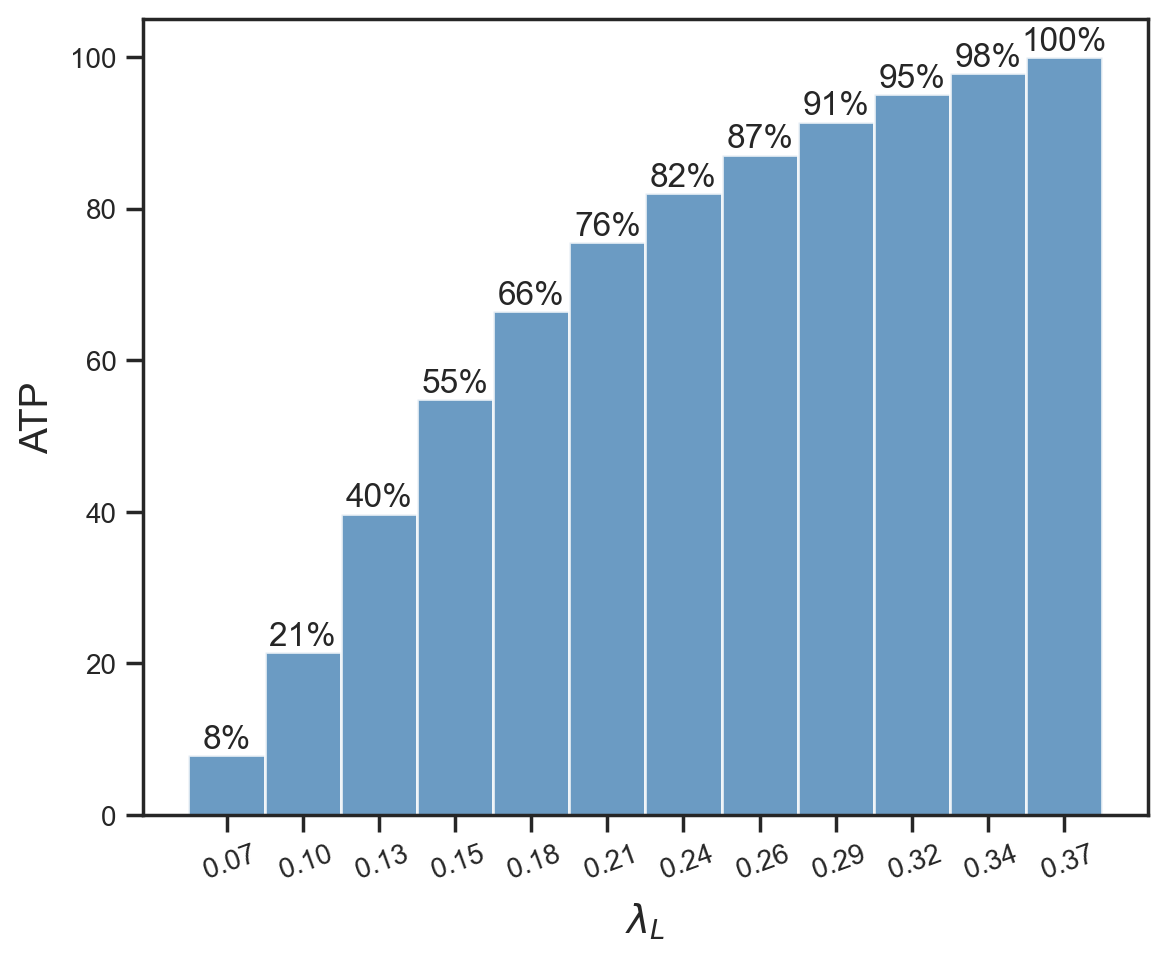

In [58]:
# Plot ATP dependency on parameter
pname = 'lmd_L'
df = df_a_pos.copy(deep=True)
nbars = 12

# interpolate
x = df.columns.values*npar_list[pdict[pname]]
y = df.loc[pname].values/a0*100
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]
X_Y_Spline = interp1d(x, y, kind='quadratic')
x1 = np.linspace(x.min(), x.max(), nbars)
y1 = X_Y_Spline(x1)

# matplotlib bar
fig, ax = plt.subplots(figsize=(6,5))
nbars = 12
x_ticks = [f'{x_:5.2f}' for x_ in x1]
bar_len = np.arange(len(x1))
bar = ax.bar(bar_len, y1, align='center', alpha=0.8, width=1.0, color='steelblue')
ax.bar_label(bar, fmt='%.f%%')
ax.set_xticks(bar_len, x_ticks, rotation=20)
ax.set_xlabel(f"{par_dict_names[pname]}", labelpad=5)
ax.set_ylabel("ATP", labelpad=5)
plt.tight_layout()
# save
fig_name = f"ATP_{pname}"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

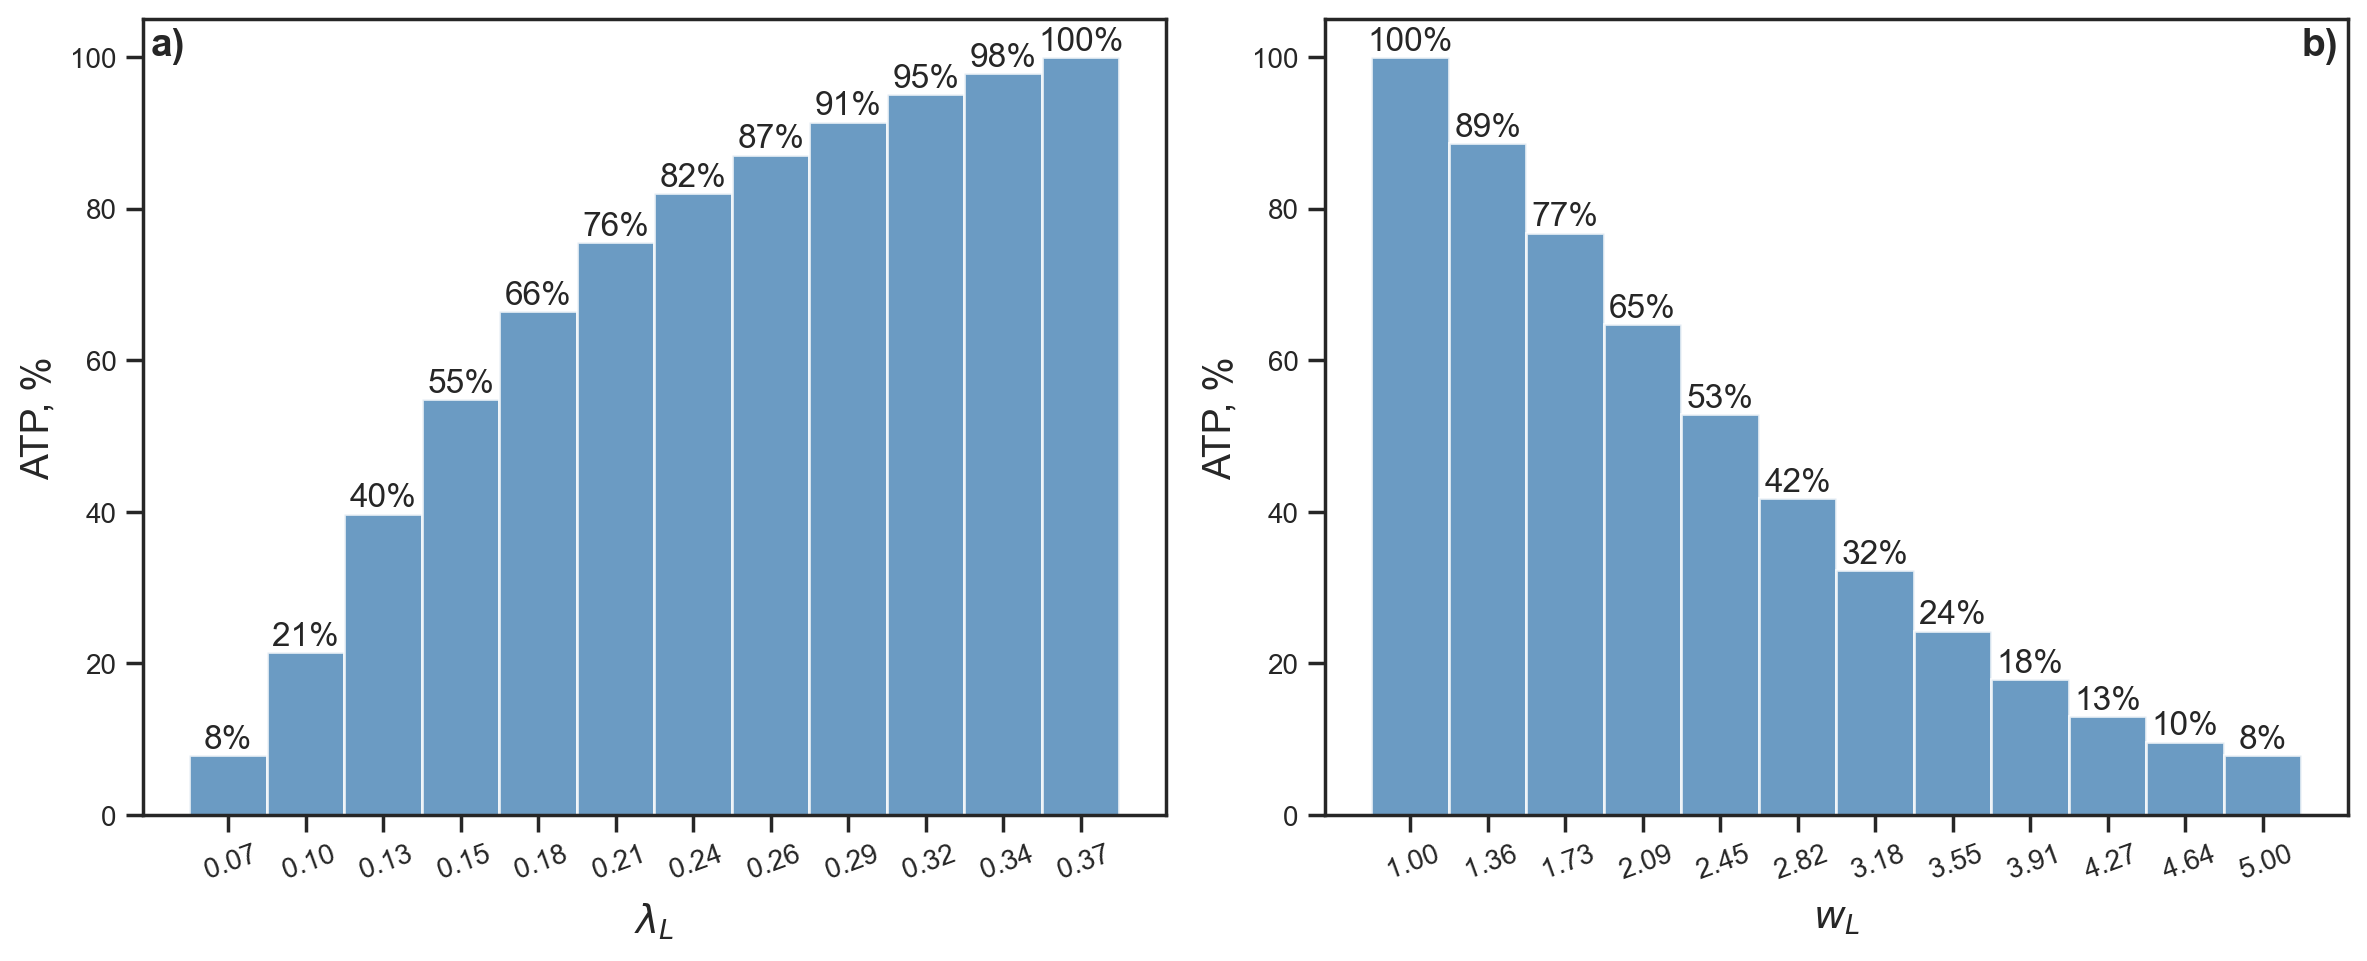

In [59]:
# Plot ATP dependency on most sensitive parameters
pname1 = 'lmd_L'
pname2 = 'wL'
df1 = df_a_pos.copy(deep=True)
df2 = df_a_neg.copy(deep=True)

# Plot bar
fig, axs = plt.subplots(1,2,figsize=(12,5))
nbars = 12

#############################################################################################
# interpolate (first plot)
x = df1.columns.values*npar_list[pdict[pname1]]
y = df1.loc[pname1].values/a0*100
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]
X_Y_Spline = interp1d(x, y, kind='quadratic')
x1 = np.linspace(x.min(), x.max(), nbars)
y1 = X_Y_Spline(x1)

# matplotlib bar
x_ticks = [f'{x_:5.2f}' for x_ in x1]
bar_len = np.arange(len(x1))
bar = axs[0].bar(bar_len, y1, align='center', alpha=0.8, width=1.0, color='steelblue')
axs[0].bar_label(bar, fmt='%.f%%')
axs[0].set_xticks(bar_len, x_ticks, rotation=20)
axs[0].set_xlabel(f"{par_dict_names[pname1]}", labelpad=5)
axs[0].set_ylabel("ATP, %", labelpad=5)

#############################################################################################
# interpolate (second plot)
x = df2.columns.values*npar_list[pdict[pname2]]
y = df2.loc[pname2].values/a0*100
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]
X_Y_Spline = interp1d(x, y, kind='quadratic')
x1 = np.linspace(x.min(), x.max(), nbars)
y1 = X_Y_Spline(x1)

# matplotlib bar
x_ticks = [f'{x_:5.2f}' for x_ in x1]
bar_len = np.arange(len(x1))
bar = axs[1].bar(bar_len, y1, align='center', alpha=0.8, width=1.0, color='steelblue')
axs[1].bar_label(bar, fmt='%.f%%')
axs[1].set_xticks(bar_len, x_ticks, rotation=20)
axs[1].set_xlabel(f"{par_dict_names[pname2]}", labelpad=5)
axs[1].set_ylabel("ATP, %", labelpad=5)

#############################################################################################
# Set annotation. Subplots names 
annot = ['a)', 'b)']
# lmd_L
i = 0
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmin+(xmax-xmin)*0.0075,ymax+(ymin-ymax)*0.01), ha='left', va='top', fontsize=14, weight="bold")
# wL
i = 1
xmin,xmax = axs[i].get_xlim()
ymin,ymax = axs[i].get_ylim()
axs[i].annotate(annot[i], (xmax+(xmin-xmax)*0.045,ymax+(ymin-ymax)*0.01), ha='left', va='top', fontsize=14, weight="bold")

#
plt.tight_layout()
# save
fig_name = f"ATP_{pname1}_{pname2}"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

# Get Heatmaps

In [60]:
# Set arrays with coefficients
cfs1 = np.array([1,0.75,0.5,0.35,0.25])
cfs2 = np.array([1,1.5,2,3,4])
pname1 = 'lmd_L'
pname2 = 'wL'
thresh = 1e-7

In [61]:
# Time
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# loop by parameters with negative derivatives (multiply)
np_a = np.zeros((len(cfs1),len(cfs2)))
for i,cf1 in tqdm(enumerate(cfs1)):
    # init. cond.
    incond = root0.x.copy()
    # loop by coeffs
    for j,cf2 in enumerate(cfs2):
        nplist = npar_list.copy()
        nplist[pdict[pname1]] = cf1*npar_list[pdict[pname1]]
        nplist[pdict[pname2]] = cf2*npar_list[pdict[pname2]]
        
        # integrate
        sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')
        if (np.abs(sol.y[:,-2]-sol.y[:,-1]) < sol.y[:,-1]*thresh).all():
            np_a[i,j] = sol.y[0,-1]
            incond = sol.y[:,-1]
        else:
            np_a[i,j] = np.nan
        
        # Plot solution
        fig, ax = plt.subplots()
        
        ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
        ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
        ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
        ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
        ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
        ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
        ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
        ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
        ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
        ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
        ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
        ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")
        
        # Set axes
        ax.set_title(f"{cf1:.3f} * {pname1} & {cf2:.3f} * {pname2}")
        ax.set_xlabel('Time, min')
        ax.set_ylabel('m.p.c.')
        ax.set_yscale('log')
        ax.axis('auto')
        ax.legend(bbox_to_anchor=[1.,1])
        plt.tight_layout()
        
        # Check directories exist. Create if not 
        dir_pic_tmp = dir_pic+f"hmp/{pname1}_{pname2}/"
        check_dir_exist(dir_pic_tmp)
        if save_pic: fig.savefig(dir_pic_tmp+f"{pname1}_{cf1:.3f}".replace('.','_')+f"_&_{pname2}_{cf2:.3f}".replace('.','_')+".png", bbox_inches='tight')
        # plt.show()
        plt.close(fig)

# to DataFrame
df_a_hm = pd.DataFrame(np_a, columns=cfs2, index=cfs1)
df_a_hm

5it [00:09,  1.87s/it]


,1.0,1.5,2.0,3.0,4.0
1.00,5.320289e+09,4.485670e+09,3.605004e+09,1.962261e+09,8.785400e+08
0.75,4.771123e+09,3.605003e+09,2.466534e+09,8.785400e+08,3.466975e+08
0.50,3.605003e+09,1.962259e+09,8.785400e+08,NaN,NaN
0.35,2.171031e+09,6.957277e+08,2.835461e+08,NaN,NaN
0.25,8.785399e+08,NaN,NaN,NaN,NaN


In [62]:
# # Write to pickle
# df_a_hm.to_pickle(dir_save+"df_a_hm.pkl")

# # Read from pickle
# df_a_hm = pd.read_pickle(dir_save+"df_a_hm.pkl")

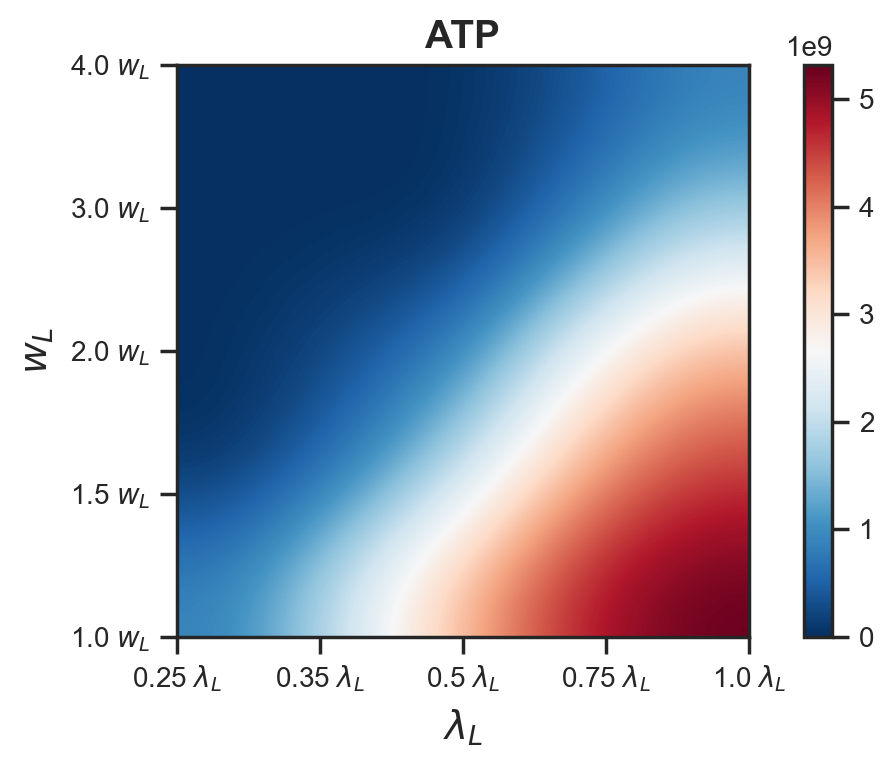

In [63]:
# Read from pickle
#np_amap = np.nan_to_num(np.array(amap).reshape(12,12))
n1 = len(cfs1)
n2 = len(cfs2)
np_amap = np.nan_to_num(df_a_hm.values).T
x_ticks_v = np.arange(0,n1)
y_ticks_v = np.arange(0,n2)

# matplotlib bar
fig, ax = plt.subplots(figsize=(6,4))
c = plt.imshow(np_amap, cmap='RdBu_r',
               extent =[min(x_ticks_v), max(x_ticks_v), min(y_ticks_v), max(y_ticks_v)], 
               interpolation ='bicubic', origin ='lower') 
ax.set_xlabel(f"{par_dict_names[pname1]}", labelpad = 5)
ax.set_ylabel(f"{par_dict_names[pname2]}", labelpad = 5)
plt.title('ATP', fontweight ="bold") 
plt.colorbar(c)

# x_ticks
x_ticks_labels = [f"{cfs1[i]} {par_dict_names[pname1]}" for i in range(n1)]
plt.xticks(x_ticks_v, x_ticks_labels, rotation = 0)
plt.gca().invert_xaxis()

# y_ticks
y_ticks_labels = [f"{cfs2[i]} {par_dict_names[pname2]}" for i in range(n2)]
plt.yticks(y_ticks_v, y_ticks_labels, rotation = 0)

# save
# plt.tight_layout()
fig_name = f"heatmap_ATP_{pname1}_{pname2}"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

# Energy consumption by processes

In [64]:
# Check real part of eigenvalues 
def en_cons_rates(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y

    # Rates of energy consumption::
    ecr = [
         # integration
         Nnt* vintL(bL_,O1_,a_)*nL + Nnt* vintS(bS_,a_)*nS,
         # replication
         vreplf(a_,bL_,O1_,bS_),
         # translation
         Naa* vq(cq_,a_)*nq,
         Naa* vL(cL_,a_)*(nL/3),
         # transcription
         Nnt* om_q(a_)*(nQ),
         Nnt* om_S(S_,a_)*nS + Nnt* om_L(L_,a_)*nL]
    
    ecr = np.array(ecr).astype(np.float64)
    return ecr

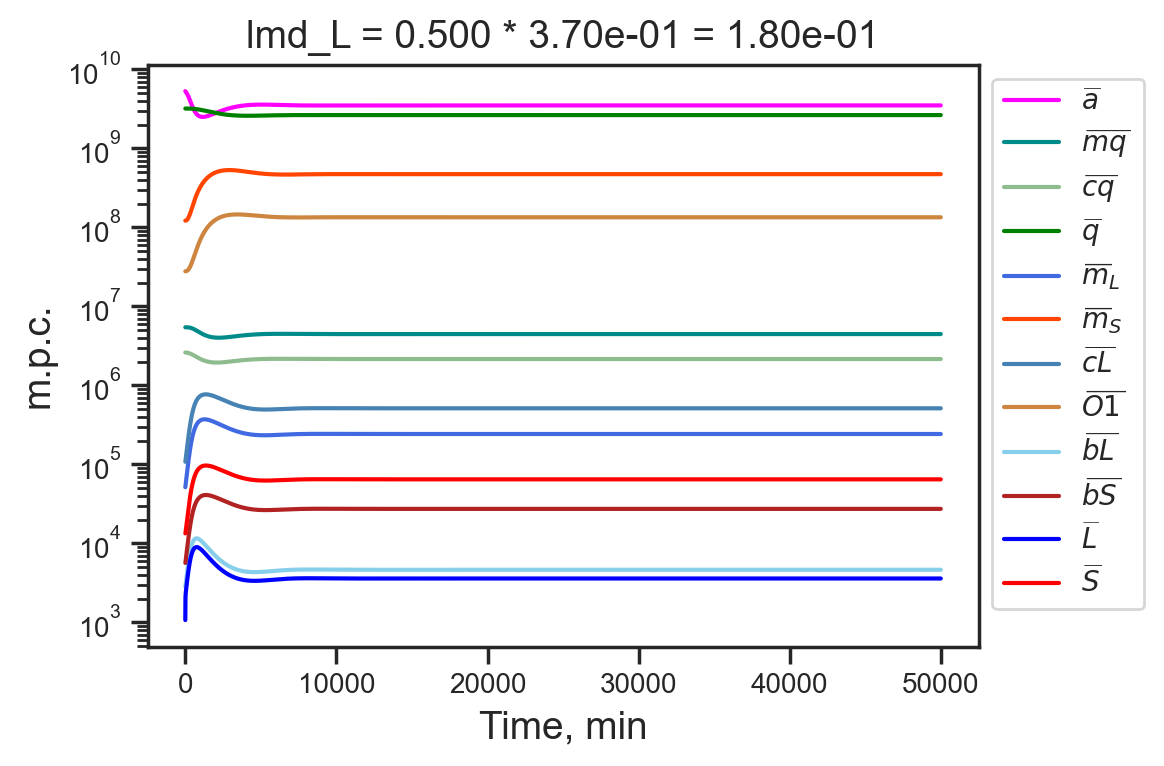

success: True
niter = 27
[3.50668980e+09 4.46216248e+06 2.15453074e+06 2.64490704e+09
 2.42208288e+05 4.72551605e+08 5.12248255e+05 1.34376419e+08
 4.62333635e+03 2.72901000e+04 3.58467170e+03 6.45536737e+04]


In [70]:
# Get solution for perturbed parameter
pname = 'lmd_L'
cf = 0.5
# 
# pname = 'wL'
# cf = 2.

# Time
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# Perturbe parameter
nplist = npar_list.copy()
# nplist[pdict[pname]] = npar_list[pdict[pname]]*cf
nplist[pdict[pname]] = round(npar_list[pdict[pname]]*cf,2)

### integrate ###
incond = root0.x.copy() # reference
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot solution
fig, ax = plt.subplots()
ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
ax.set_title(f"{pname} = {cf:.3f} * {npar_list[pdict[pname]]:.2e} = {nplist[pdict[pname]]:.2e}")
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

### Find root ###
incond = sol.y[:,-1]
root1 = root(solve_syst_par, incond, method='lm', options={'maxiter':10000})
print("success:", root1.success)
print("niter =", root1.nfev)
print(root1.x)

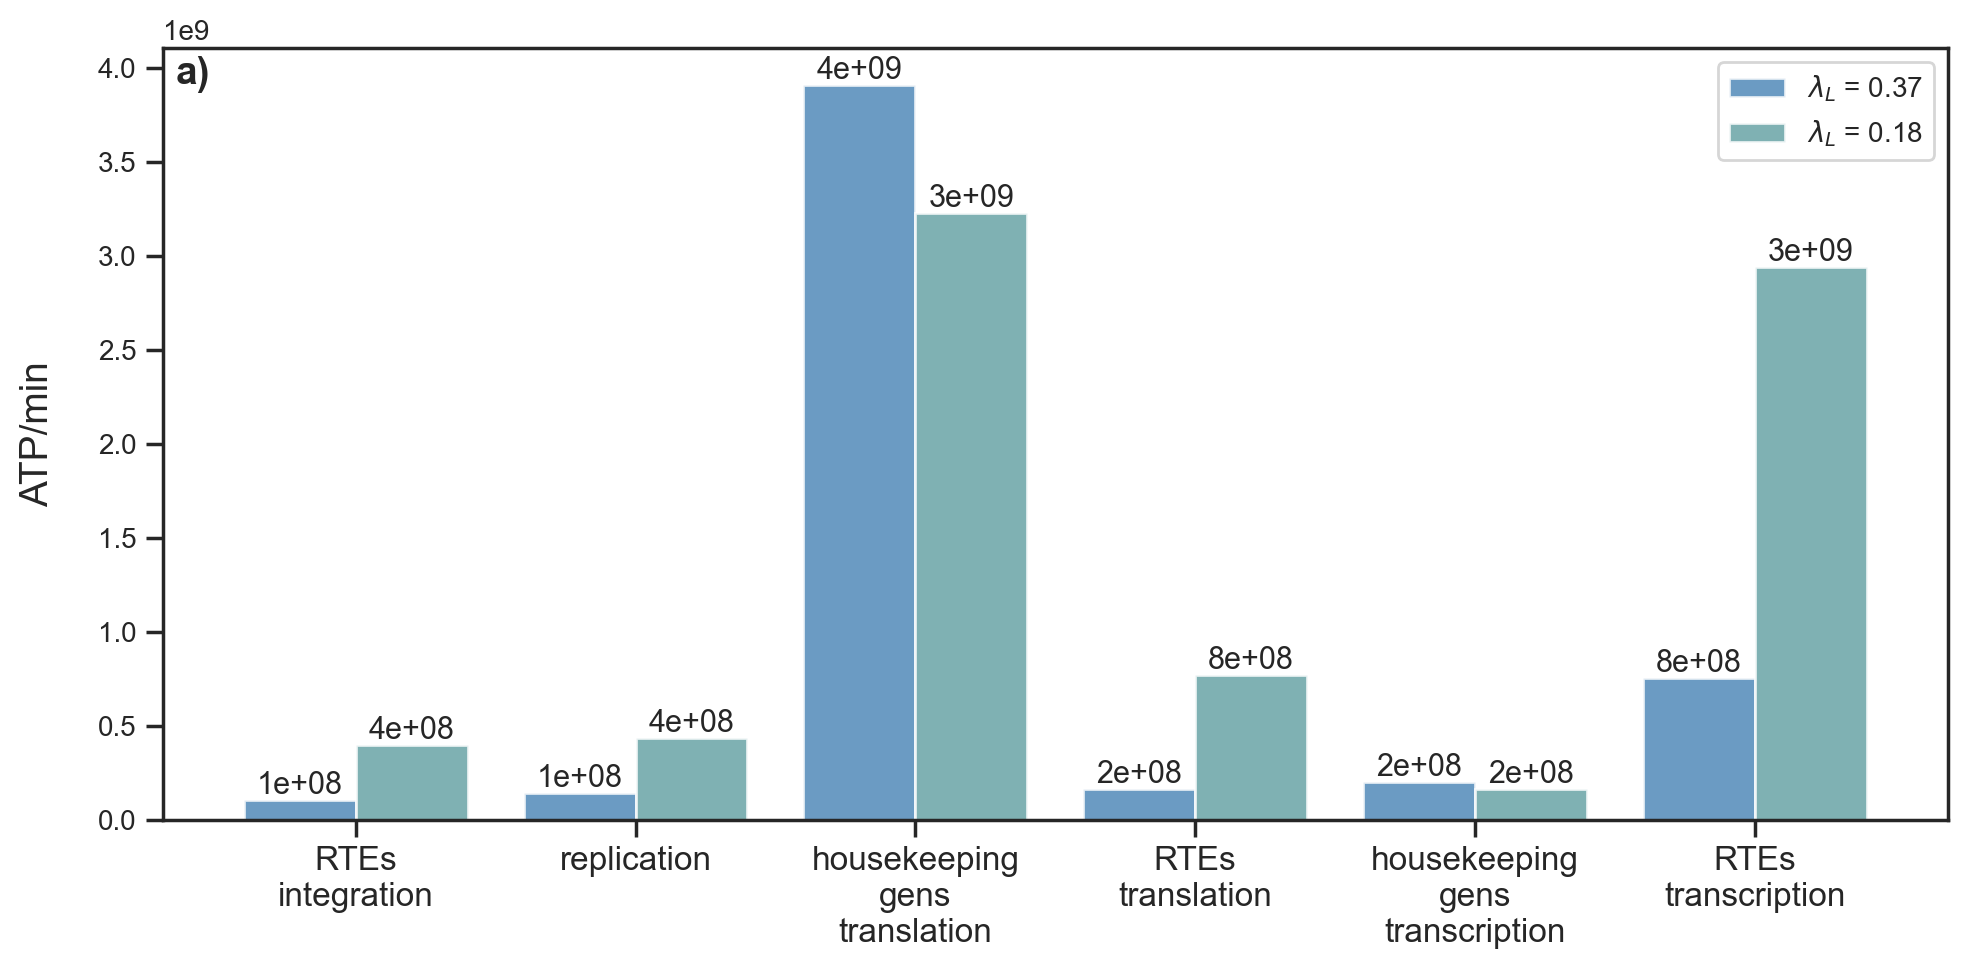

In [66]:
## Set figure
fig, ax = plt.subplots(figsize=(10,5))
x_ticks = ('RTEs\nintegration', 'replication', 'housekeeping\ngens\ntranslation', 'RTEs\ntranslation', 
           'housekeeping\ngens\ntranscription', 'RTEs\ntranscription')
bar_ticks = np.arange(len(x_ticks))

# Rates in reference
ecr0 = en_cons_rates(root0.x)

# Rates with perturbed parameter
ecr1 = en_cons_rates(root1.x)

# matplotlib bar
bar0 = plt.bar(x=bar_ticks-0.2, height=ecr0, width=0.4, align='center', alpha=0.8, label=f'{par_dict_names[pname]} = {npar_list[pdict[pname]]}', color='steelblue')
bar1 = plt.bar(x=bar_ticks+0.2, height=ecr1, width=0.4, align='center', alpha=0.8, label=f'{par_dict_names[pname]} = {nplist[pdict[pname]]}', color='cadetblue')

# matplotlib bar (black & white)
# bar0 = plt.bar(x=bar_ticks-0.2, height=ecr0, width=0.4, align='center', alpha=0.8, label=f'{par_dict_names[pname]} = {npar_list[pdict[pname]]}', color='dimgrey')
# bar1 = plt.bar(x=bar_ticks+0.2, height=ecr1, width=0.4, align='center', alpha=0.8, label=f'{par_dict_names[pname]} = {nplist[pdict[pname]]}', color='darkgrey')

# Annotate
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.annotate('a)', (xmin+(xmax-xmin)*7e-3,ymax+(ymin-ymax)*1e-2), ha='left', va='top', fontsize=14, weight="bold")

# Set axes
plt.bar_label(bar0, fmt='%.0e', fontsize=11)
plt.bar_label(bar1, fmt='%.0e', fontsize=11)
plt.xticks(bar_ticks, x_ticks, fontsize=12, rotation=0)
ax.set_ylabel(r'ATP/min', labelpad=15, rotation=90)
plt.legend() 
plt.tight_layout()
# save figure
fig_name = f"en_cons_{pname}"
if save_pic: plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_svg+f"{fig_name}.svg", bbox_inches='tight')
plt.show()

# ATP drop

In [72]:
# Set perturbed init. conditions
pert_idxs = [10] # L
# cfs = np.logspace(0,3,11)
cfs = np.array([1,1.5,2,4,8,16,25,50,100,200,400,600,800,1000])
ncfs = len(cfs)

# set array with in-conds.
inconds = root0.x.copy()
for i in range(1,ncfs):
    inconds = np.vstack((inconds, root0.x))
    
# perturbe
for i in range(ncfs):
    inconds[i,pert_idxs] *= cfs[i]

In [73]:
# Time
t_start = 0.
t_finish = 6000.
step = 1/60 # 1 seconds
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# integrate from different initial conditions
nplist = npar_list.copy()
sols_a = np.zeros((ncfs,len(t)))
for i in tqdm(range(ncfs)):
    incond = inconds[i].copy()
    sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')
    sols_a[i,:] = sol.y[0,:]
    
    # Plot solution
    fig, ax = plt.subplots()
    ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
    ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
    ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
    ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
    ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
    ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
    ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
    ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
    ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
    ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
    ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
    ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")
    
    # Set axes
    pert_names = f"{var_keys[pert_idxs]}".replace("'","").replace('[','').replace(']','')
    ax.set_title(pert_names.replace(' ',' & ')+f" * {cfs[i]}")
    ax.set_xlabel('Time, min')
    ax.set_ylabel('m.p.c.')
    ax.set_yscale('log')
    ax.axis('auto')
    plt.legend(bbox_to_anchor=[1.,1])
    plt.tight_layout()
    
    # Check directories exist. Create if not 
    dir_pic_tmp = dir_pic+f"incond/{pert_names}/".replace(' ','_')
    check_dir_exist(dir_pic_tmp)
    if save_pic: fig.savefig(dir_pic_tmp+pert_names.replace(' ','_')+f"_{cfs[i]:>06}".replace('.','_')+".png", bbox_inches='tight')
    # plt.show()
    plt.close(fig)

# Save last solution
sol_tmp = cp.deepcopy(sol)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.00s/it]


In [74]:
# # Write to pickle
# write2pickle(sols_a, dir_save+"sols_a_L.pkl")
# write2pickle(sol_tmp, dir_save+"sol_tmp.pkl")

# # Read from pickle
# sol_tmp = read_pickle(dir_save+"sol_tmp.pkl")
# sols_a = read_pickle(dir_save+"sols_a_S.pkl")

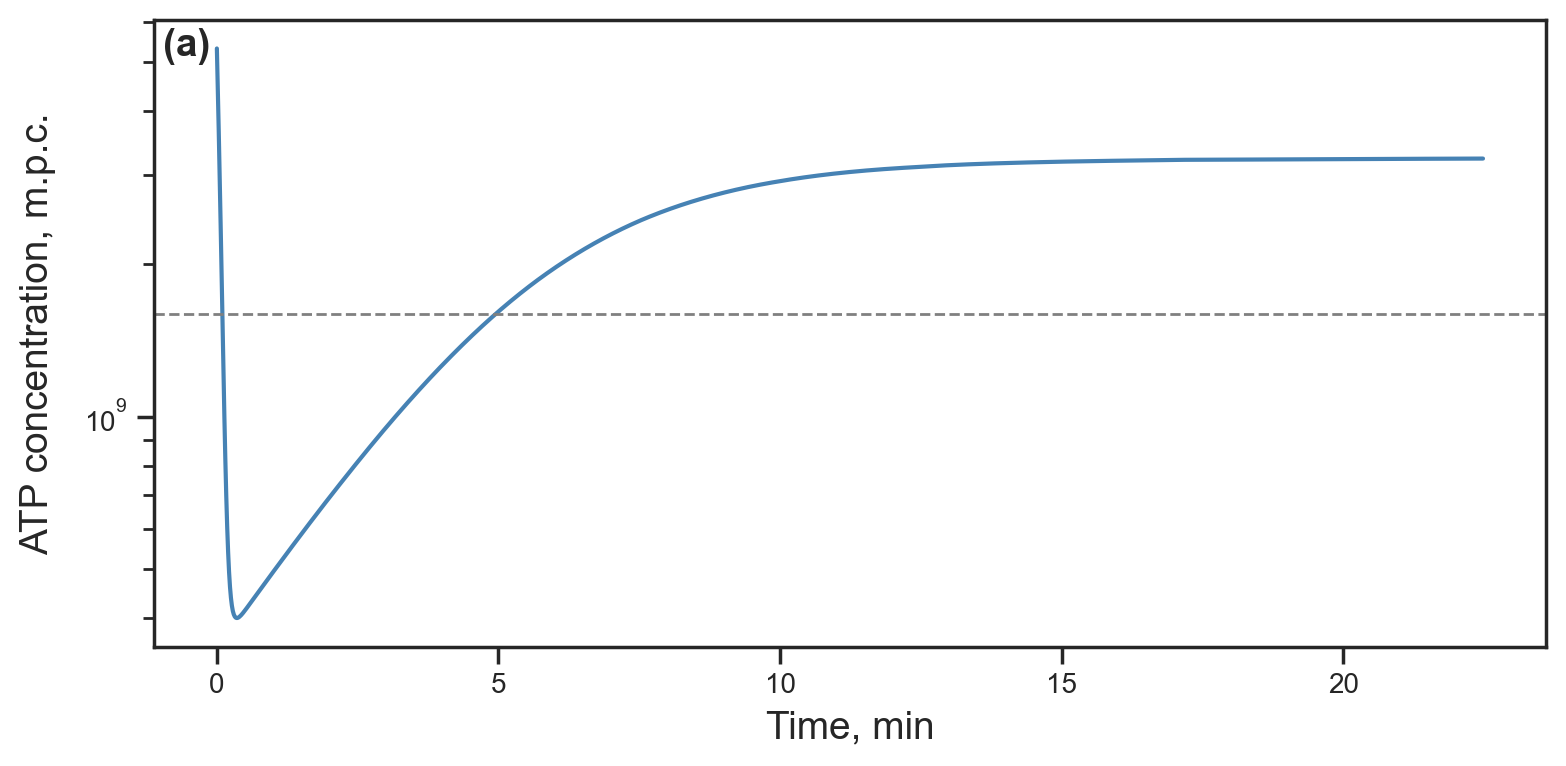

In [75]:
# Plot ATP filure
fig, ax = plt.subplots(figsize=(8,4))

# Set illustraion
lim = 0.3
n0 = 0
n = 1350

# interpolate
x = sol_tmp.t[n0:n].copy()
y = sols_a[-1,n0:n].copy()
# X_Y_Spline = interp1d(x, y, kind='quadratic') 
# # Return evenly spaced numbers over a specified interval.
# x1 = np.linspace(x.min(), x.max(), 500)
# y1 = X_Y_Spline(x1)

# plot (do not use interpolant)
ax.plot(x, y, '-', color="steelblue", lw=1.5)

# plot stationary solution
plt.axhline(root0.x[0]*lim, color='grey', linestyle='--', lw=1)

# Set axes
# ax.set_title("Illustration of ATP drop")
ax.set_xlabel('Time, min')
ax.set_ylabel("ATP concentration, m.p.c.", rotation=90, labelpad=10)
ax.set_yscale('log')
ax.axis('auto')
#ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()

# Annotate
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.annotate('(a)', (xmin+(xmax-xmin)*7e-3,ymax+(ymin-ymax)*4e-2), ha='left', va='top', fontsize=14, weight="bold")

# save figure
dir_pic_tmp = dir_pic+"incond/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
pert_names = f"{var_keys[pert_idxs]}".replace("'","").replace('[','').replace(']','')
fig_name = "pert_incond_ATP_dyn_"+pert_names.replace(' ','_')
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

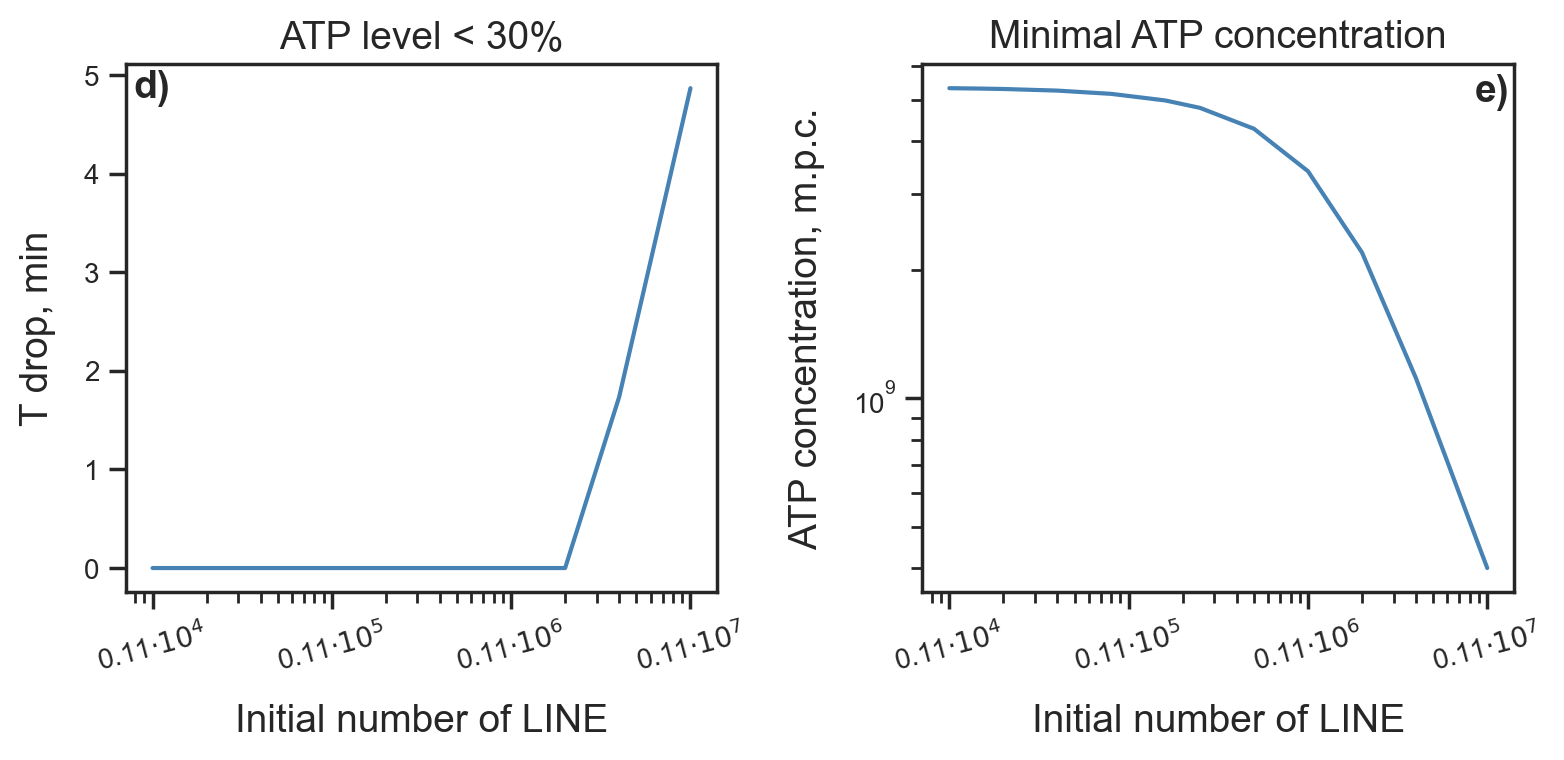

In [76]:
# Plot ATP filure
fig, axs = plt.subplots(1,2,figsize=(8,4))
pert_names = f"{var_keys[pert_idxs]}".replace("'","").replace('[','').replace(']','').replace(' ',' & ')
pert_names = "LINE"

# set ticks
x_ticks_v = [1,10,100,1000]
idx = pert_idxs[-1]
# LINE
# sval = f"{(root0.x[idx]/1e3):.2f}"
# x_ticks_labels = [sval+r"$\cdot10^3$",sval+r"$\cdot10^4$",sval+r"$\cdot10^5$",sval+r"$\cdot10^6$"]
# sval = f"{root0.x[idx]:.0f}"
# x_ticks_labels = [sval,sval+r"$\cdot10$",sval+r"$\cdot100$",sval+r"$\cdot1000$"]
# SINE
sval = f"{(root0.x[idx]/1e4):.2f}"
x_ticks_labels = [sval+r"$\cdot10^4$",sval+r"$\cdot10^5$",sval+r"$\cdot10^6$",sval+r"$\cdot10^7$"]

###################################################################################
# Plot time of failure
lim = 0.3

# calculate time of failure
ta_falls = np.zeros(ncfs)
for i,sol_a in enumerate(sols_a):
    ta_falls[i] = (sol_a < root0.x[0]*lim).sum()*step

# interpolate
x = cfs
y = ta_falls
# X_Y_Spline = interp1d(x, y, kind='quadratic')
# # Return evenly spaced numbers over a specified interval.
# x1 = np.linspace(x.min(),x.max(),5)
# y1 = X_Y_Spline(x1)

# plot (do not use interpolant)
axs[0].plot(x, y, '-', color="steelblue", lw=1.5)

# Set axes
axs[0].set_title(f"ATP level < {lim*100:.0f}%")
axs[0].set_xlabel('Initial number of '+pert_names, labelpad=10)
axs[0].set_ylabel("T drop, min", rotation=90, labelpad=10)
axs[0].set_xscale('log')
#axs[0].set_yscale('log')
axs[0].set_xticks(x_ticks_v, x_ticks_labels, rotation = 15)
axs[0].axis('auto')

#########################################################################################
# Plot Minimal ATP

# calculate minimal ATP
a_drop = np.zeros(ncfs)
for i,sol_a in enumerate(sols_a):
    a_drop[i] = sol_a.min()

# interpolate
x = cfs
y = a_drop
# X_Y_Spline = interp1d(x, y, kind='quadratic')
# # Return evenly spaced numbers over a specified interval.
# x1 = np.linspace(x.min(),x.max(),5)
# y1 = X_Y_Spline(x1)

# plot (do not use interpolant)
axs[1].plot(x, y, '-', color="steelblue", lw=1.5)

# Set axes
axs[1].set_title(f"Minimal ATP concentration")
axs[1].set_xlabel('Initial number of '+pert_names, labelpad=10)
axs[1].set_ylabel("ATP concentration, m.p.c.", rotation=90, labelpad=10)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xticks(x_ticks_v, x_ticks_labels, rotation = 15)
axs[1].axis('auto')

#########################################################################################
# Annotate
annot = ['d)', 'e)']
# plot 1
xmin,xmax = axs[0].get_xlim()
ymin,ymax = axs[0].get_ylim()
axs[0].annotate(annot[0], (xmin+(xmax-xmin)*5e-5,ymax+(ymin-ymax)*1e-2), ha='left', va='top', fontsize=14, weight="bold")
# plot 2
xmin,xmax = axs[1].get_xlim()
ymin,ymax = axs[1].get_ylim()
axs[1].annotate(annot[1], (xmax+(xmin-xmax)*0.4,ymax+(ymin-ymax)*5e-2), ha='left', va='top', fontsize=14, weight="bold")

#plt.legend(bbox_to_anchor=[1.,1])
# save figure
plt.tight_layout()
dir_pic_tmp = dir_pic+"incond/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
# pert_names = f"{var_keys[pert_idxs]}".replace("'","").replace('[','').replace(']','')
fig_name = "pert_incond_ATP_fall_"+pert_names.replace(' ','_')
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

# More dynamics

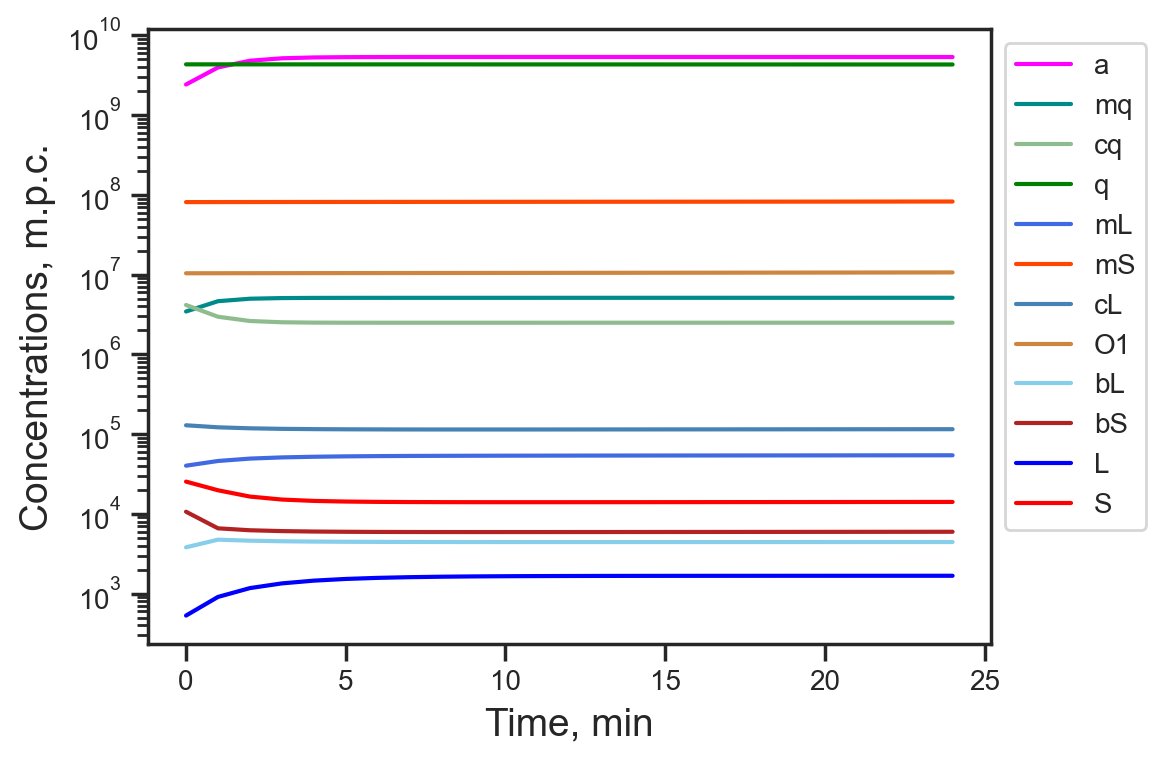

In [77]:
# Random perturbation of all variables by 100%
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 25 #int((t_finish-t_start)/step)

### set initial conditions
nplist = npar_list.copy()
incond = root0.x.copy()

### add white noise
seed = 12345
rng = np.random.default_rng(seed)
rfloat = rng.random(12)
incond += incond*(rfloat*2-1)*1

### Perturbe some variables
# incond[-2:] *= 10

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0],  label=r"a")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1],  label=r"mq")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2],  label=r"cq")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3],  label=r"q")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4],  label=r"mL")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5],  label=r"mS")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6],  label=r"cL")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7],  label=r"O1")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8],  label=r"bL")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9],  label=r"bS")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"L")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"S")

# Set axes
# ax.set_title('Dynamics')
ax.set_xlabel('Time, min')
ax.set_ylabel('Concentrations, m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()

# save figure
dir_pic_tmp = dir_pic+"dyn/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
fig_name = "dyn_pert_rand_100"
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

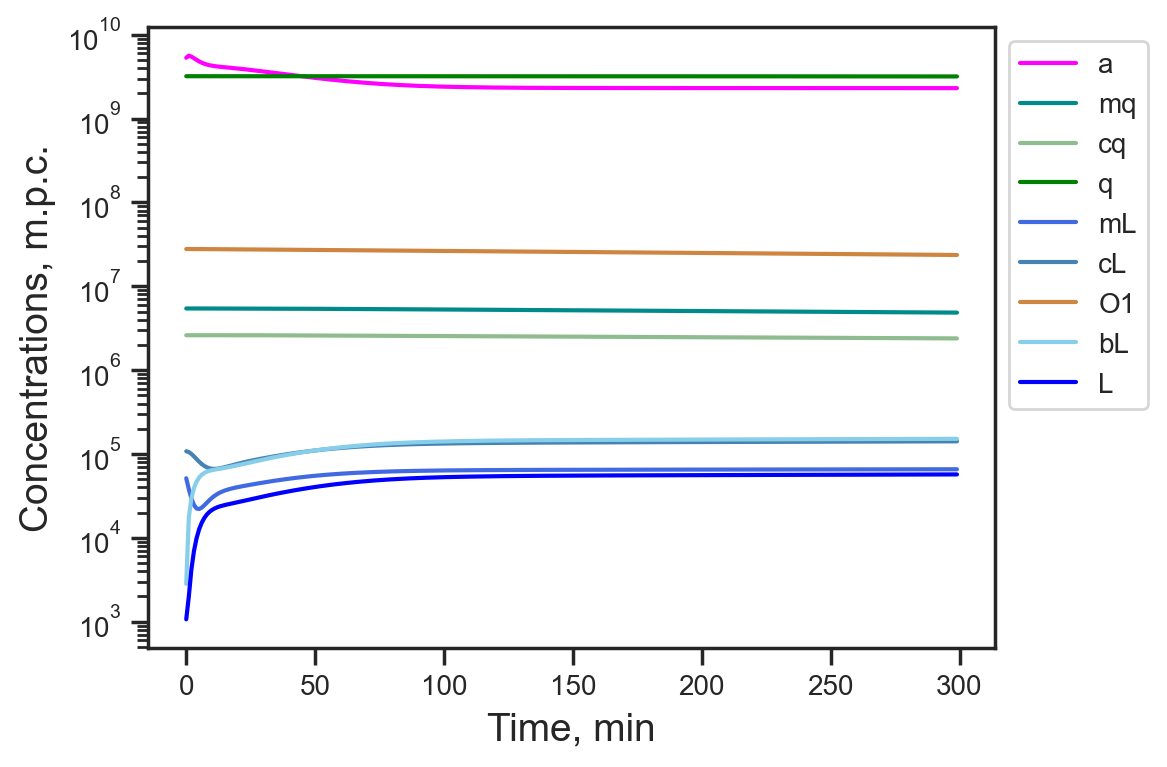

In [79]:
# Knock-out SINE
t_start = 0.
t_finish = 5000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 300 #int((t_finish-t_start)/step)

### set initial conditions
nplist = npar_list.copy()
incond = root0.x.copy()

### add white noise
# seed = 12345
# rng = np.random.default_rng(seed)
# rfloat = rng.random(12)
# incond += incond*(rfloat*2-1)*1

### Perturbe some variables
incond[-1] = 0
incond[-3] = 0
incond[-7] = 0

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0],  label=r"a")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1],  label=r"mq")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2],  label=r"cq")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3],  label=r"q")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4],  label=r"mL")
# ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5],  label=r"mS")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6],  label=r"cL")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7],  label=r"O1")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8],  label=r"bL")
# ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9],  label=r"bS")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"L")
# ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"S")

# Set axes
# ax.set_title('Dynamics')
ax.set_xlabel('Time, min')
ax.set_ylabel('Concentrations, m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
fig.set_tight_layout(True)

# save figure
dir_pic_tmp = dir_pic+"dyn/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
fig_name = "dyn_knock_S"
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

# Mutual behavior

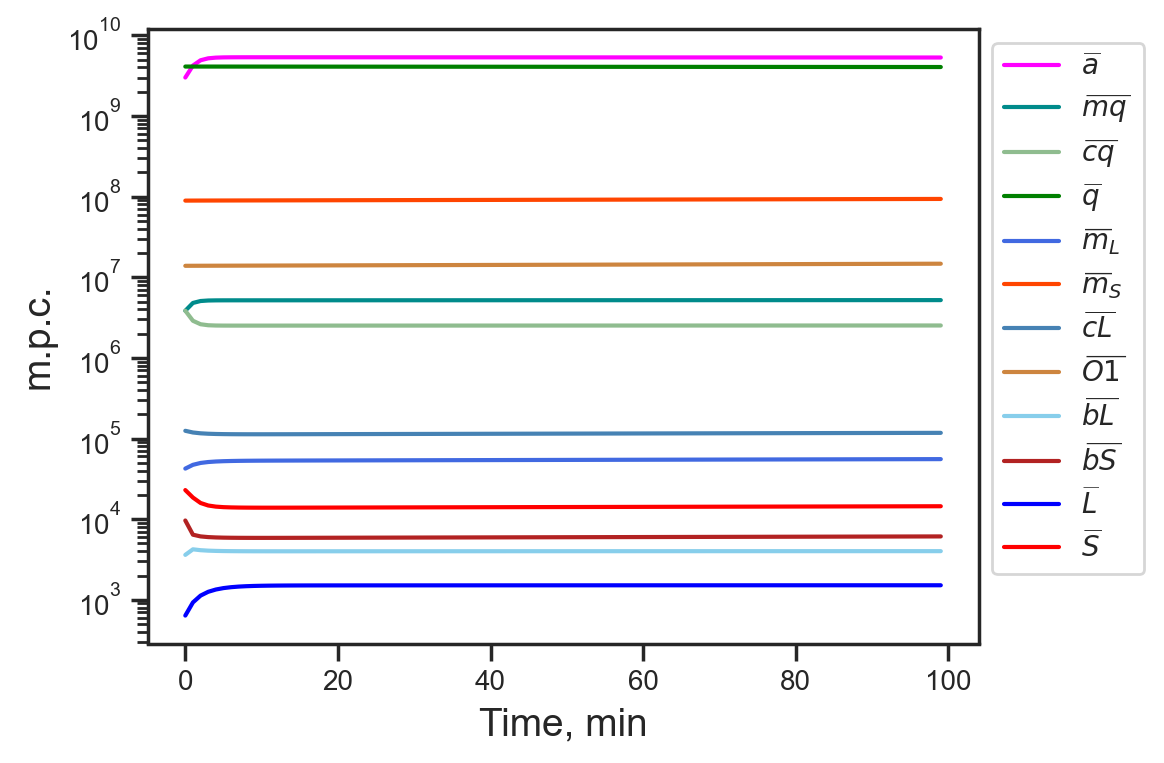

In [80]:
# Check with reference solution
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 100 #int((t_finish-t_start)/step)

### set initial conditions
nplist = npar_list.copy()
incond = root0.x.copy()

### add white noise
seed = 12345
rng = np.random.default_rng(seed)
rfloat = rng.random(12)
incond += incond*(rfloat*2-1)*0.8

# ### Perturbe some variables
# incond[-2:] *= 10

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot reference
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
# ax.set_title('Dynamics')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

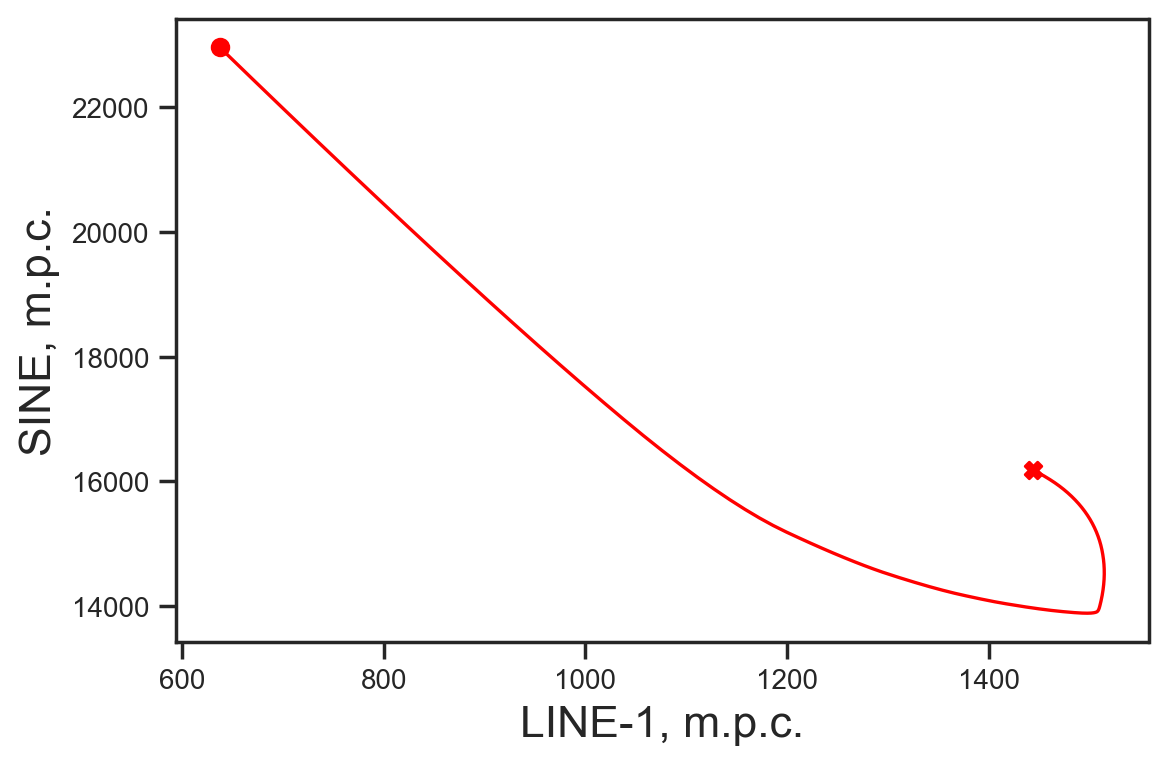

In [81]:
# Set limit
n = int((t_finish-t_start)/step)

# Interpolate
fL = interp1d(sol.t[:n], sol.y[-2,:n], kind='quadratic')
times = np.arange(sol.t[:n].min(), sol.t[:n].max(), 0.1)
yL = fL(times)
fS = interp1d(sol.t[:n], sol.y[-1,:n], kind='quadratic')
yS = fS(times)

# PLot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(yL, yS, '-', lw=1.2, color='red')
ax.scatter(yL[0], yS[0], marker='o', color='red')    
ax.scatter(yL[-1], yS[-1], marker='X', color='red')
#ax.scatter(root0.x[-2], root0.x[-1], marker='X', color='blue')

# Set axes
ax.set_xlabel('LINE-1, m.p.c.', fontsize=16)
ax.set_ylabel('SINE, m.p.c.', fontsize=16)
ax.axis('auto')
plt.tight_layout()

# save figure
dir_pic_tmp = dir_pic+"mutual/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
fig_name = f"mut_LS_seed_{seed}"
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

## Multiple integrations

In [82]:
# Check with reference solution
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)

# integrate in loop with random perturbations of initial conditions
nplist = npar_list.copy()
sols = []
for i in tqdm(range(10)):
    ### incond
    rng = np.random.default_rng(i)
    rfloat = rng.random(12)
    incond = root0.x.copy()
    incond += incond*(rfloat*2-1)*0.8
    
    # integration
    sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')
    sols.append(sol)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.96it/s]


plot: 0


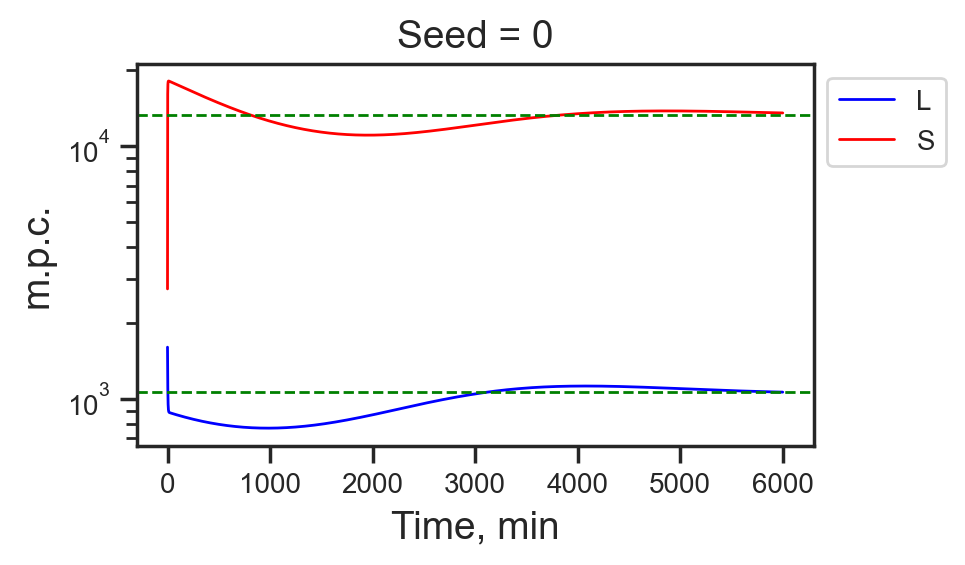

plot: 1


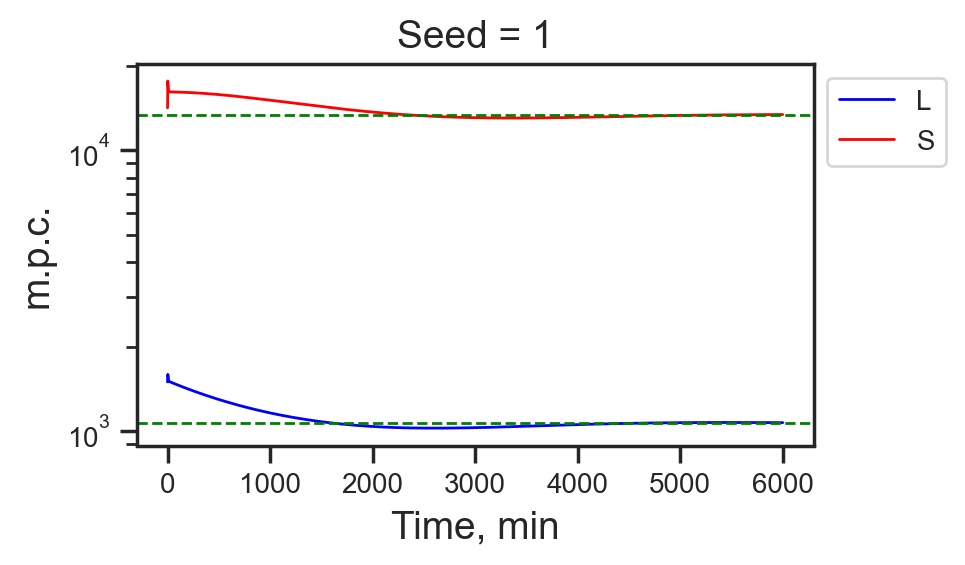

plot: 2


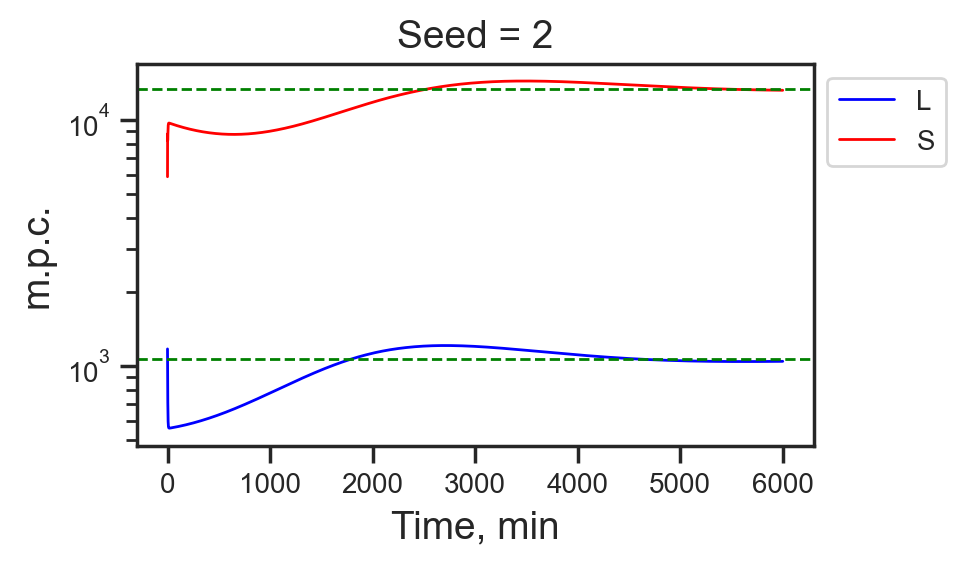

plot: 3


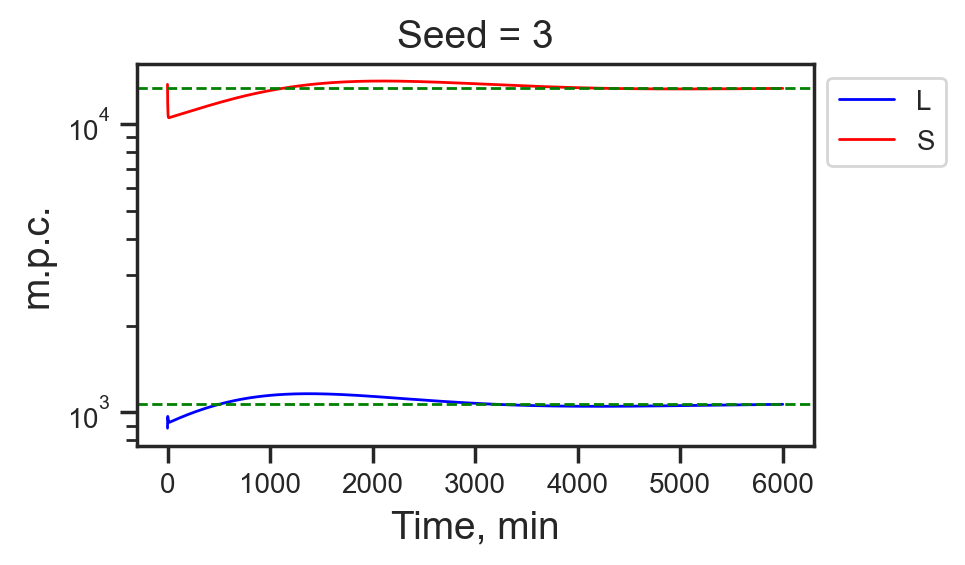

plot: 4


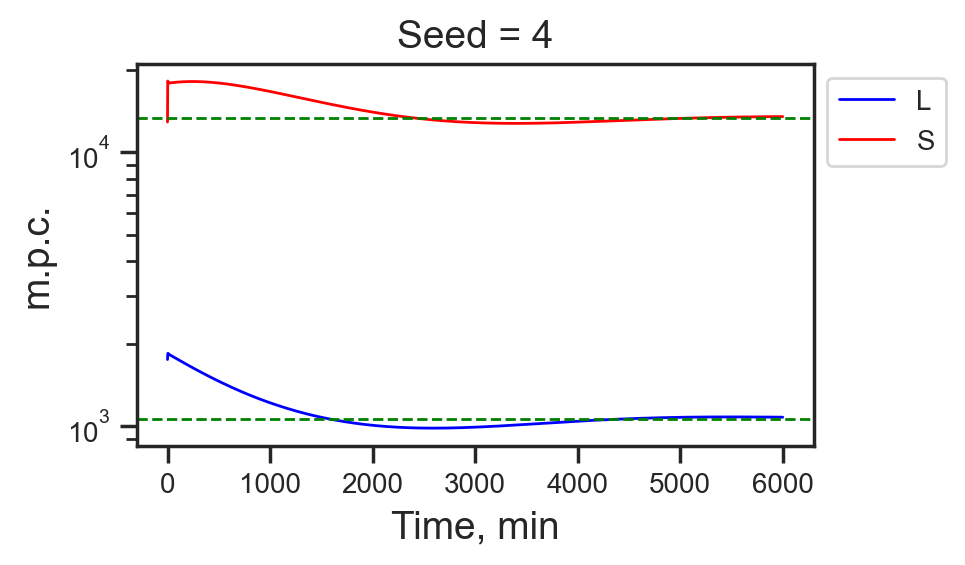

plot: 5


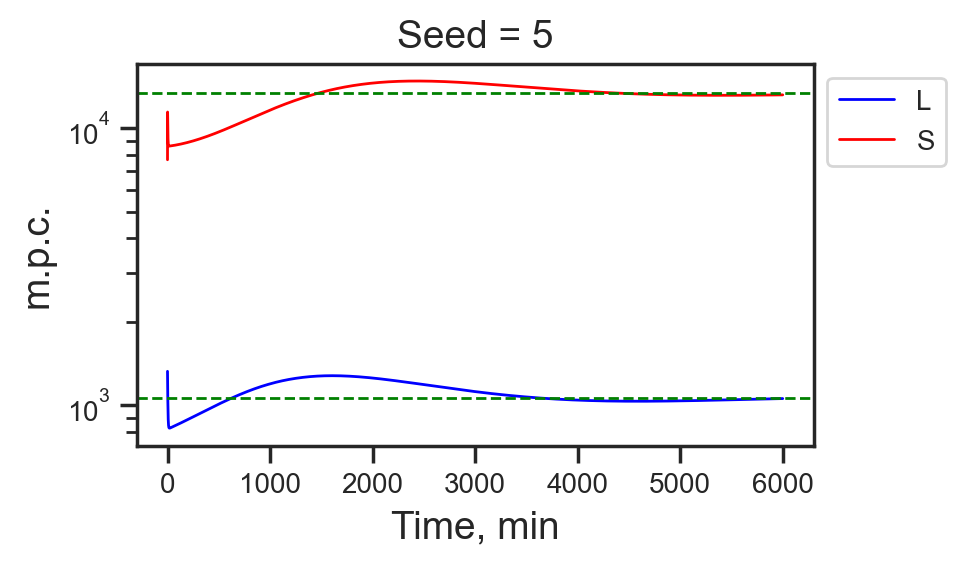

plot: 6


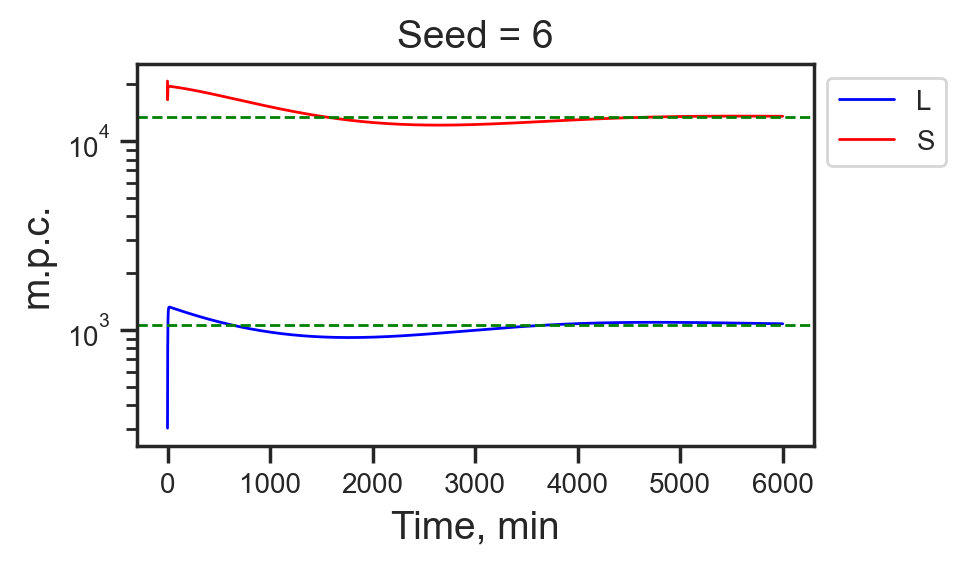

plot: 7


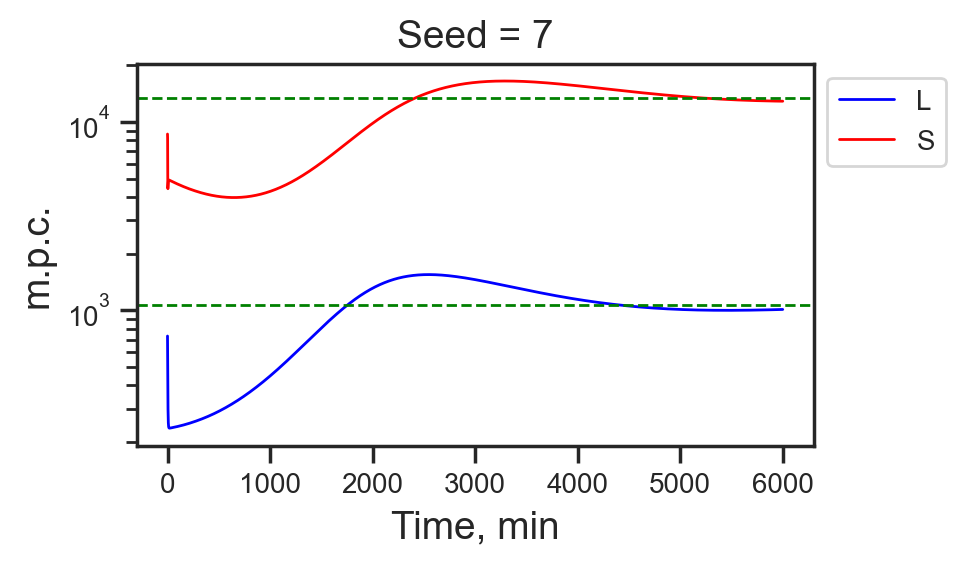

plot: 8


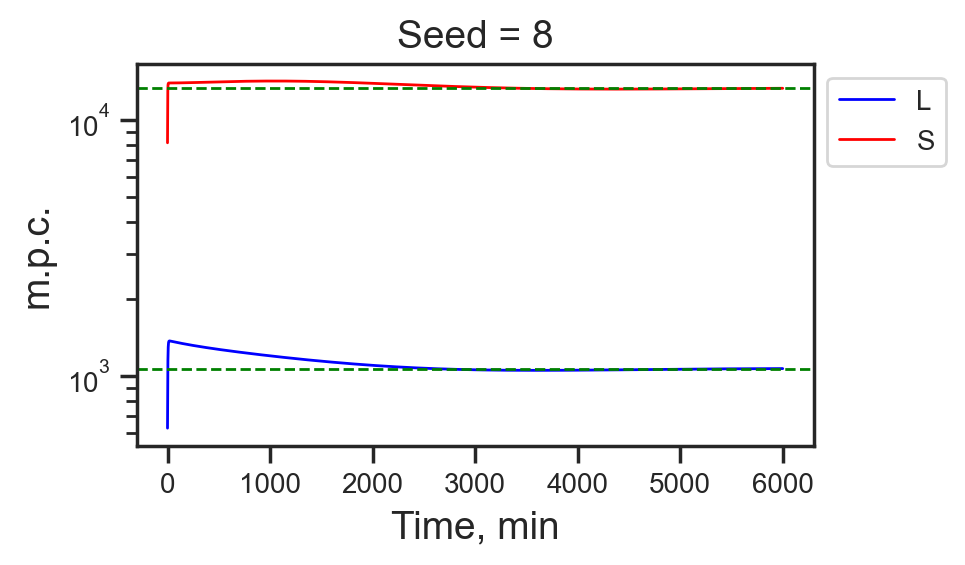

plot: 9


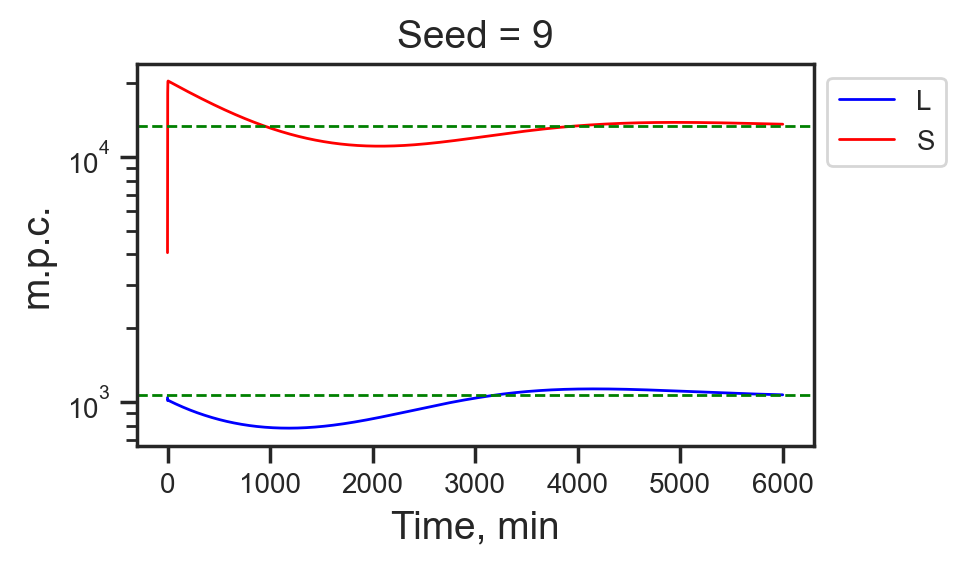

In [83]:
### Plot in loop ###
n = 6000 #int((t_finish-t_start)/step)

# plot L and S dynamics
for i,sol in enumerate(sols):
    
    # Plot
    print("plot:", i)
    fig, ax = plt.subplots(figsize=(5,3))
    
    for j in [-2,-1]:
        ax.plot(sol.t[:n], sol.y[j,:n], '-', color=colormap[j], label=var_keys[j])
        # plot stationary solution
        plt.axhline(root0.x[j], color='g', linestyle='--', lw=1)
        
    # Set axes
    ax.set_title(f'Seed = {i}', fontsize=14)
    ax.set_xlabel('Time, min')
    ax.set_ylabel('m.p.c.')
    ax.set_yscale('log')
    ax.axis('auto')
    ax.legend(bbox_to_anchor=[1.,1])
    plt.tight_layout()
    
    # save figure
    dir_pic_tmp = dir_pic+"mutual/"
    check_dir_exist(dir_pic_tmp)
    check_dir_exist(dir_pic_tmp+"svg/")
    fig_name = f"dyn_LS_seed_{i}"
    if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
    if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
    plt.show()

In [84]:
# some functions (round to some number)
def round_up(x, num):
    return int(ceil(x / num)) * num
    
def round_down(x, num):
    return int(floor(x / num)) * num

# Find max and min (LINE-1 and SINE)
maxL, minL = [], []
maxS, minS = [], []
for sol in sols:
    maxL0, minL0 = sol.y[-2,:].max(), sol.y[-2,:].min()
    maxS0, minS0 = sol.y[-1,:].max(), sol.y[-1,:].min()
    maxL.append(maxL0)
    minL.append(minL0)
    maxS.append(maxS0)
    minS.append(minS0)

# to numpy
maxL = np.array(maxL)
minL = np.array(minL)
maxS = np.array(maxS)
minS = np.array(minS)

# find max & min values
maxL0, minL0 = maxL.max(), minL.min()
maxS0, minS0 = maxS.max(), minS.min()
        
# Round_up
up2 = 100
maxL0 = round_up(maxL0, up2)
maxS0 = round_up(maxS0, up2)
# Round_down
minL0 = round_down(minL0, up2)
minS0 = round_down(minS0, up2)

# print
print("maxL =", maxL0)
print("minL =", minL0)
print("maxS =", maxS0)
print("minS =", minS0)

maxL = 1900
minL = 200
maxS = 20900
minS = 2700


plot: 0


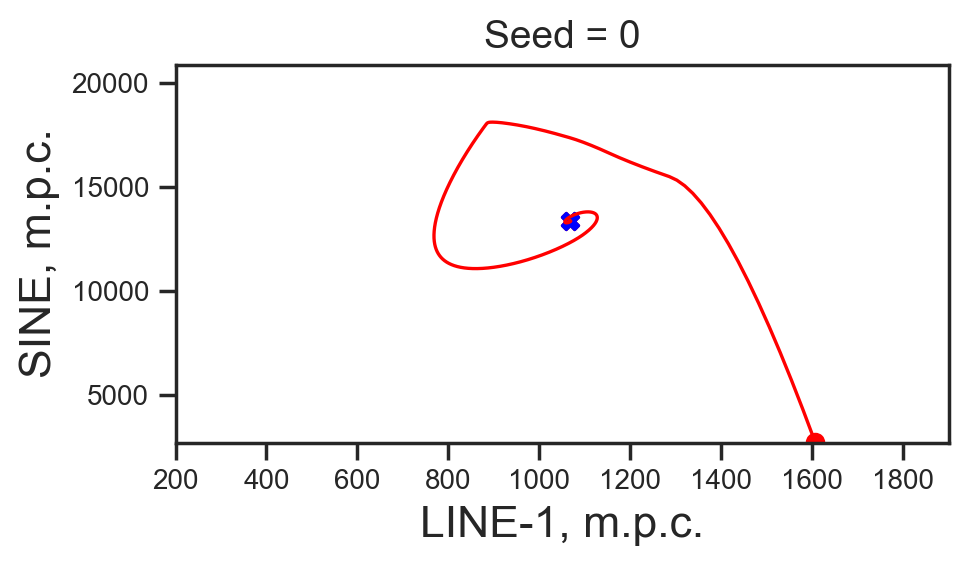

plot: 1


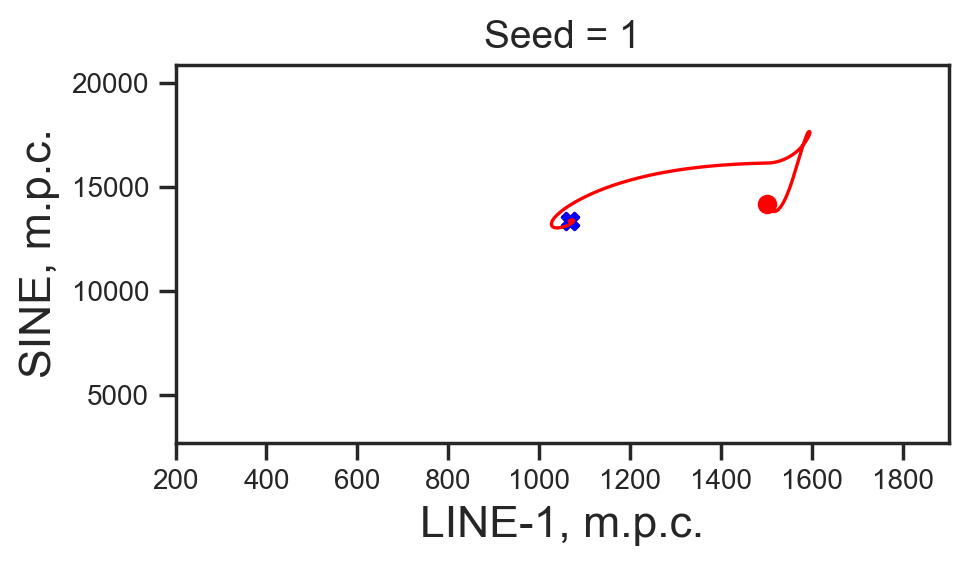

plot: 2


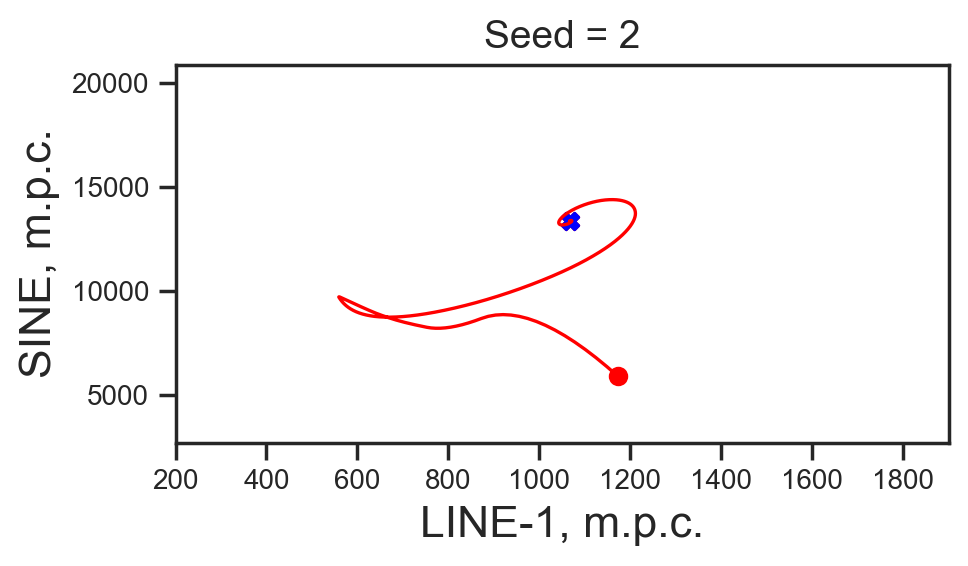

plot: 3


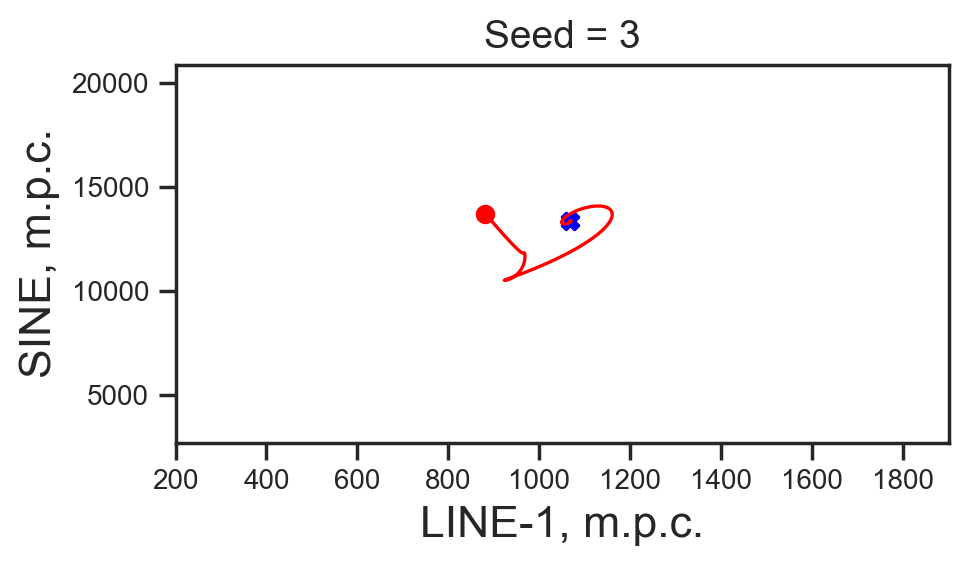

plot: 4


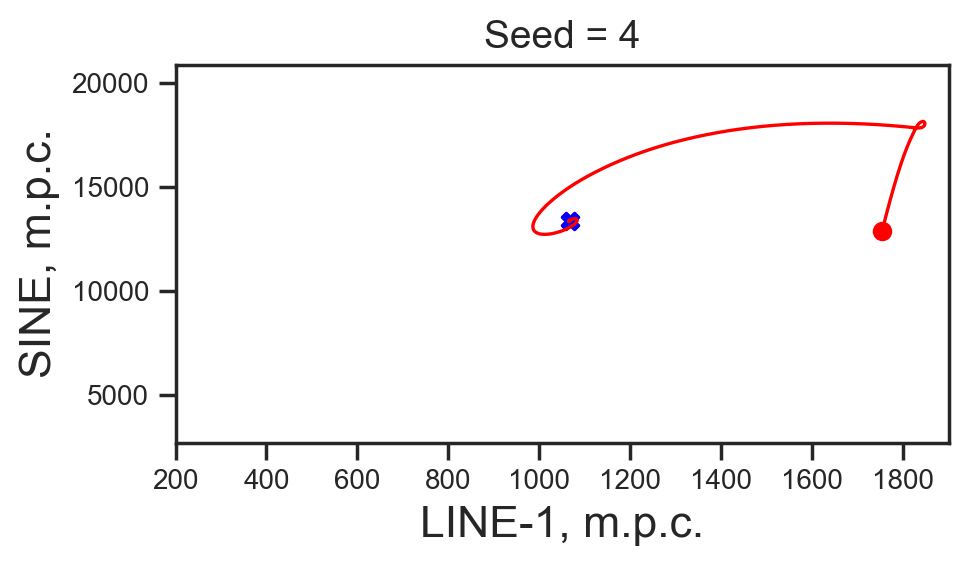

plot: 5


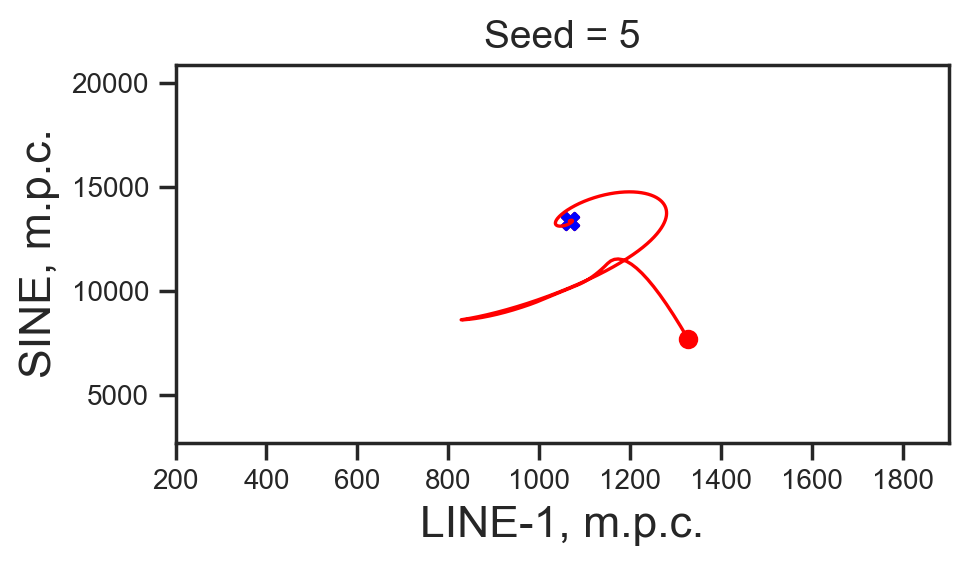

plot: 6


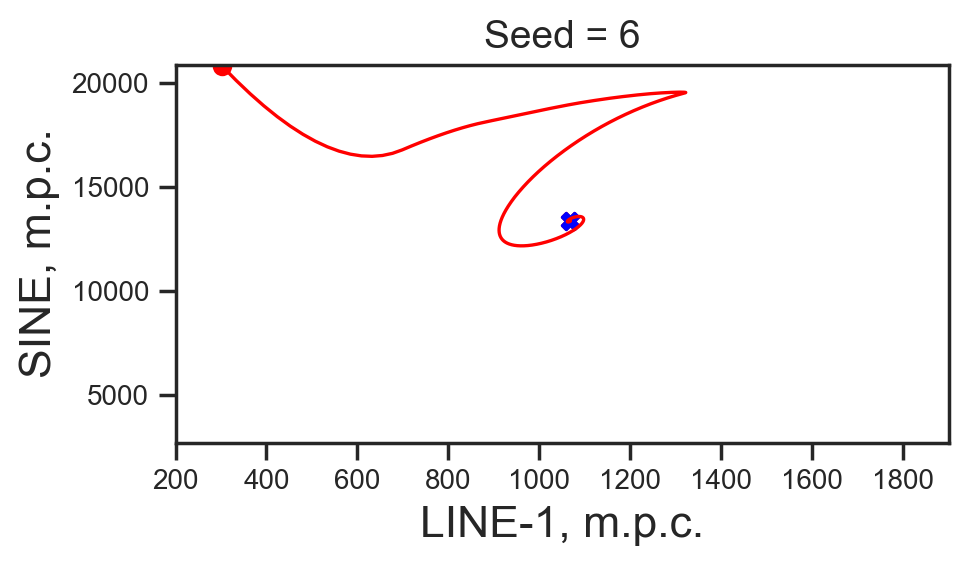

plot: 7


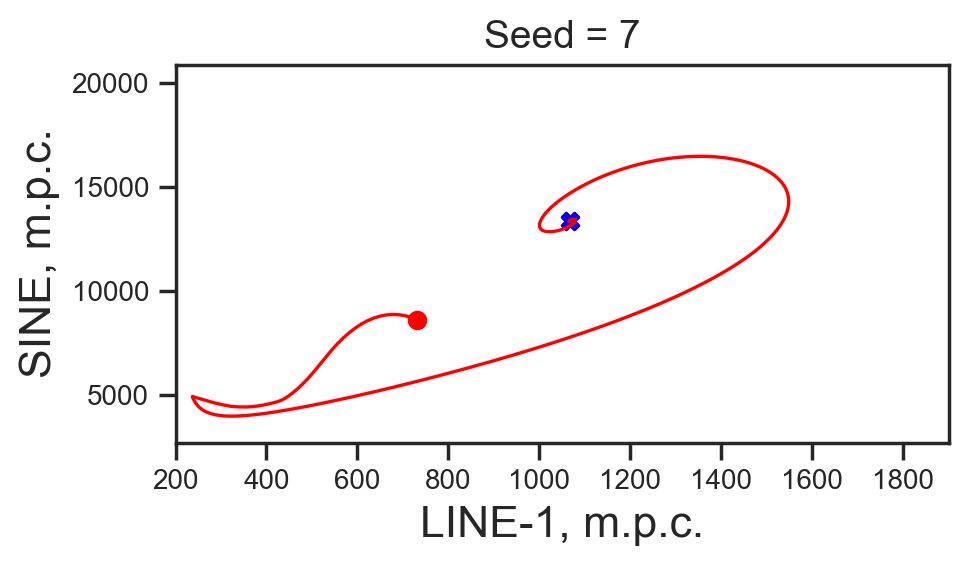

plot: 8


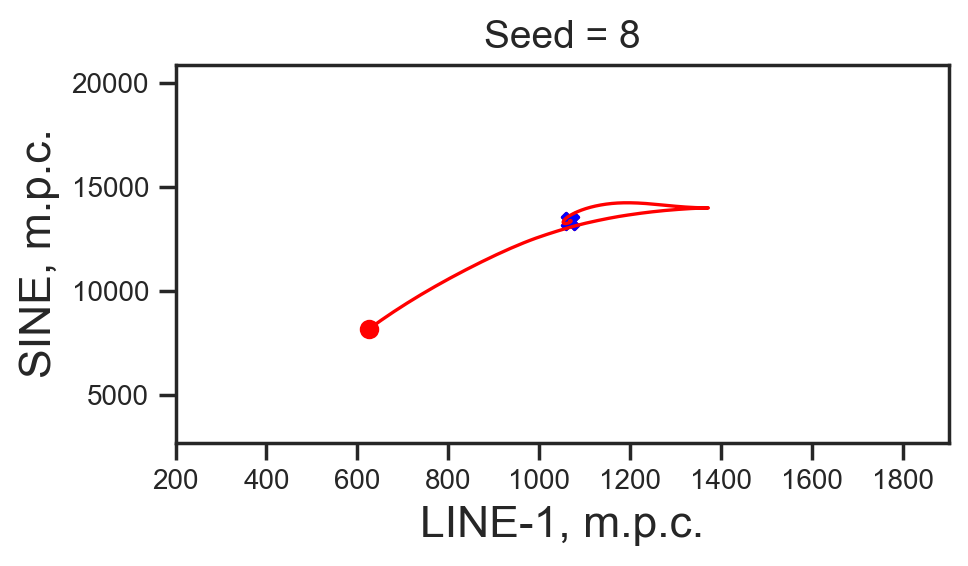

plot: 9


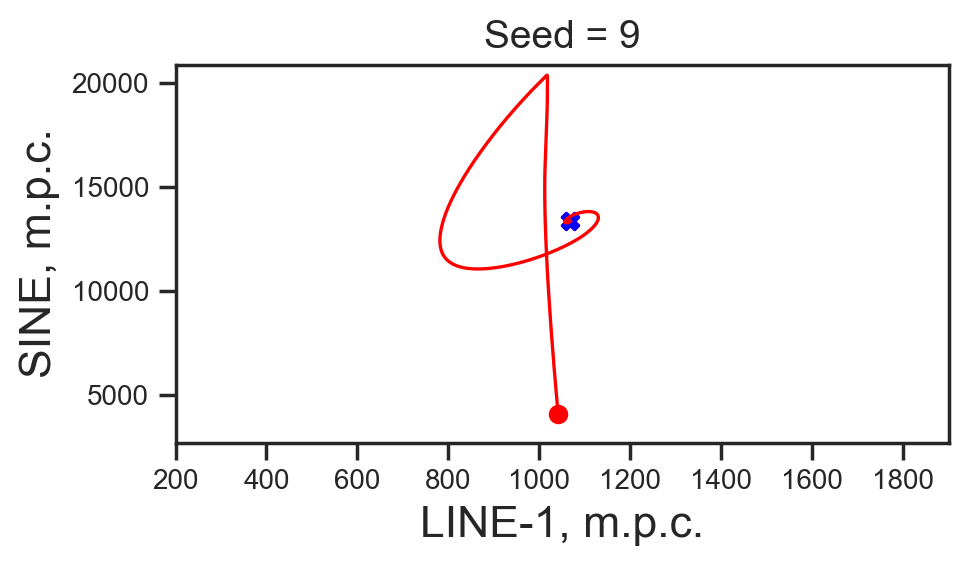

In [85]:
# Plot in loop
for i,sol in enumerate(sols):

    # Interpolate
    fL = interp1d(sol.t, sol.y[-2,:], kind='quadratic')
    times = np.arange(sol.t.min(), sol.t.max(), 0.1)
    yL = fL(times)
    fS = interp1d(sol.t, sol.y[-1,:], kind='quadratic')
    yS = fS(times)
    
    # PLot
    print("plot:", i)
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(yL, yS, '-', lw=1.2, color='red')
    ax.scatter(yL[0], yS[0], marker='o', color='red')
    ax.scatter(yL[-1], yS[-1], marker='X', color='red')
    ax.scatter(root0.x[-2], root0.x[-1], marker='X', color='blue')
    
    # Label axes
    ax.set_xlim(minL0, maxL0)
    ax.set_ylim(minS0, maxS0)
    # ax.set_xlim(round_down(minL[i], up2), round_up(maxL[i], up2))
    # ax.set_ylim(round_down(minS[i], up2), round_up(maxS[i], up2))
    ax.set_title(f'Seed = {i}')
    ax.set_xlabel('LINE-1, m.p.c.', fontsize=16)
    ax.set_ylabel('SINE, m.p.c.', fontsize=16)
    # ax.axis('auto')
    plt.tight_layout()
    
    # save figure
    dir_pic_tmp = dir_pic+"mutual/"
    check_dir_exist(dir_pic_tmp)
    check_dir_exist(dir_pic_tmp+"svg/")
    fig_name = f"mut_LS_seed_{i}"
    if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
    if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
    plt.show()